In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.linalg import expm
import scipy.linalg as spl
import sympy as sp

In [2]:
A = np.array([
    [0, 0,         1,             0],
    [0, 0,         0,             1],
    [0, 0.060985, -7.4894,  -0.0875],
    [0, 1.08167, -0.82153, -1.55195]
])
B= np.array([
    [0],
    [0],
    [0.98343],
    [0.10787]
])

In [3]:
def discrete_system_coef(h):
    """ Функция пересчета матриц A и B для дискретной системы
    
    Принимает только параметры класса \\
    На выход подаются A и B
    """
    Ad = spl.expm(A * h)

    n_factorial, T = 1, 1

    Bd = np.zeros(A.shape)
    var = np.identity(A.shape[0])
    for n in range(1, 20):
        n_factorial = n_factorial * n
        T = T * h
        Bd = Bd + var * (T / n_factorial)
        var = var @ A
    Bd = Bd @ B
    return Ad, Bd

In [4]:
Al = np.array([
    [-6, -8, 4],
    [1, 0, -1],
    [0, 0, -1]
])
eigenvalues, eigenvectors = np.linalg.eig(Al)

print("Собственные числа:", eigenvalues)
print("Собственные векторы:\n", eigenvectors)

Собственные числа: [-4. -2. -1.]
Собственные векторы:
 [[-0.9701425   0.89442719  0.78446454]
 [ 0.24253563 -0.4472136  -0.19611614]
 [ 0.          0.          0.58834841]]


In [5]:
A_transposed = A.T

print("Транспонированная матрица A:\n", A_transposed)

Транспонированная матрица A:
 [[ 0.        0.        0.        0.      ]
 [ 0.        0.        0.060985  1.08167 ]
 [ 1.        0.       -7.4894   -0.82153 ]
 [ 0.        1.       -0.0875   -1.55195 ]]


In [6]:
eigenvalues, eigenvectors = np.linalg.eig(A_transposed)

print("Собственные числа:", eigenvalues)
print("Собственные векторы:\n", eigenvectors)

Собственные числа: [ 0.52103246 -2.05945329 -7.50292918  0.        ]
Собственные векторы:
 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  9.91067090e-01]
 [ 8.99040872e-01 -4.57767272e-01 -1.05003266e-02  5.59178436e-08]
 [-4.46719983e-02 -1.32999572e-01  9.99809303e-01  1.33152788e-01]
 [ 4.35579985e-01  8.79067823e-01  1.64651291e-02 -7.50720899e-03]]


Система не является устойчивой. Хотим передвинуть собственные значения для достижения устойчивости.

## 5

### 5 a

In [5]:
S_ = np.array([
    [0, 8.99040872e-01, -4.46719983e-02, 4.35579985e-01],
    [1,     0,      0,     0],
    [0,     0,      1,     0],
    [0,     0,      0,     1]
]) 
S = np.linalg.inv(S_)

print("S:\n", S) 

S:
 [[ 0.          1.          0.          0.        ]
 [ 1.11229648  0.          0.04968851 -0.48449409]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]]


In [6]:
A_1 = S_ @ A @ S
B_1 = S_ @ B
print("A^: ", A_1)
print("B^: ", B_1)

A^:  [[ 5.21032464e-01  0.00000000e+00  3.26277956e-10  1.38163606e-09]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 6.78334010e-02  0.00000000e+00 -7.48636975e+00 -1.17046872e-01]
 [ 1.20313774e+00  0.00000000e+00 -7.67783433e-01 -2.07601272e+00]]
B^:  [[0.00305423]
 [0.        ]
 [0.98343   ]
 [0.10787   ]]


In [7]:
theta_1 = (-1 - 5.21032464e-01) / 0.00305423
print("theta^_1 = ", theta_1)

theta^_1 =  -498.0084879003874


In [8]:
theta_ = np.array([
    [theta_1, 0, 0, 0],
])
theta = theta_ @ S_
print("theta = ", theta)


theta =  [[   0.         -447.72998523   22.24703432 -216.92252969]]


In [9]:
Ac = A + B @ theta
print(Ac)

[[   0.            0.            1.            0.        ]
 [   0.            0.            0.            1.        ]
 [   0.         -440.25011437   14.38900097 -213.41562337]
 [   0.          -47.21496351    1.57825759  -24.95138328]]


In [10]:
eigenvalues, eigenvectors = np.linalg.eig(Ac)

print("Собственные числа:", eigenvalues)

Собственные числа: [ 0.         -7.50292914 -2.05945331 -0.99999987]


Для линейной системы


In [11]:
def model(x, t, A, B, theta):
    u = np.dot(theta, x)  # Управление по обратной связи
    dxdt = np.dot(A, x) + np.dot(B, u)
    return dxdt

t = np.linspace(0, 20, 1000)  # Временной интервал 0-8 секунд
x0 = [0, np.pi/8, 0, 0]         # Начальные условия [x1, x2, x3, x4]

solution = odeint(model, x0, t, args=(A, B, theta))
x1 = solution[:, 0]  # Позиция (x)
x2 = solution[:, 1]  # Угол (θ)
x3 = solution[:, 2]  # Скорость позиции (ẋ)
x4 = solution[:, 3]  # Угловая скорость (θ̇)

Для нелинейной системы

In [12]:
g = 9.81
Kt = 1.726
Ks = 4.487
Bcq = 5.4
m =  0.56
l =  0.1778
Bp = 1.4
I = 0.89
M = 1.206

A1 = m + M
C1 = m * l
D1 = I + m * l**2
K1 = Kt*Ks + Bcq

def system(x, Y):
    y1, y2, y3, y4 = Y

    #u = u1 * y1 + u2 * y2 + u3 * y3 + u4 * y4
    f1 = -K1*y3 - C1 * y4**2 * np.sin(y2)
    f2 = -Bp*y4 + C1 * g * np.sin(y2)

    dydt = [
        y3,
        y4,
        (m * y4 * np.cos(y2) - m * y4**2 * np.sin(y2)) / (m + M) + -440.25011437 * y2 + 14.38900097 * y3 + -213.41562337 * y4,
        (m * l * ((m * y4 * np.cos(y2) - m * y4**2 * np.sin(y2)) / (m + M) + -440.25011437 * y2 + 14.38900097 * y3 + -213.41562337 * y4) * np.cos(y2) + m * g * l * np.sin(y2)) / (I + m * l**2) + -47.21496351 * y2 + 1.57825759 * y3 + -24.95138328 * y4,
    ]

    return dydt


x0 = 0.0
xT = 20.0
y0 = [0.0, np.pi/8, 0.0, 0.0]
x_span = (x0, xT)  # интервал по x

# Временной интервал: от 0 до 8 секунд
t = np.linspace(0, 20, 1000)

# Интегрирование системы
sol = solve_ivp(system, x_span, y0, t_eval=np.linspace(x0, xT, 100))

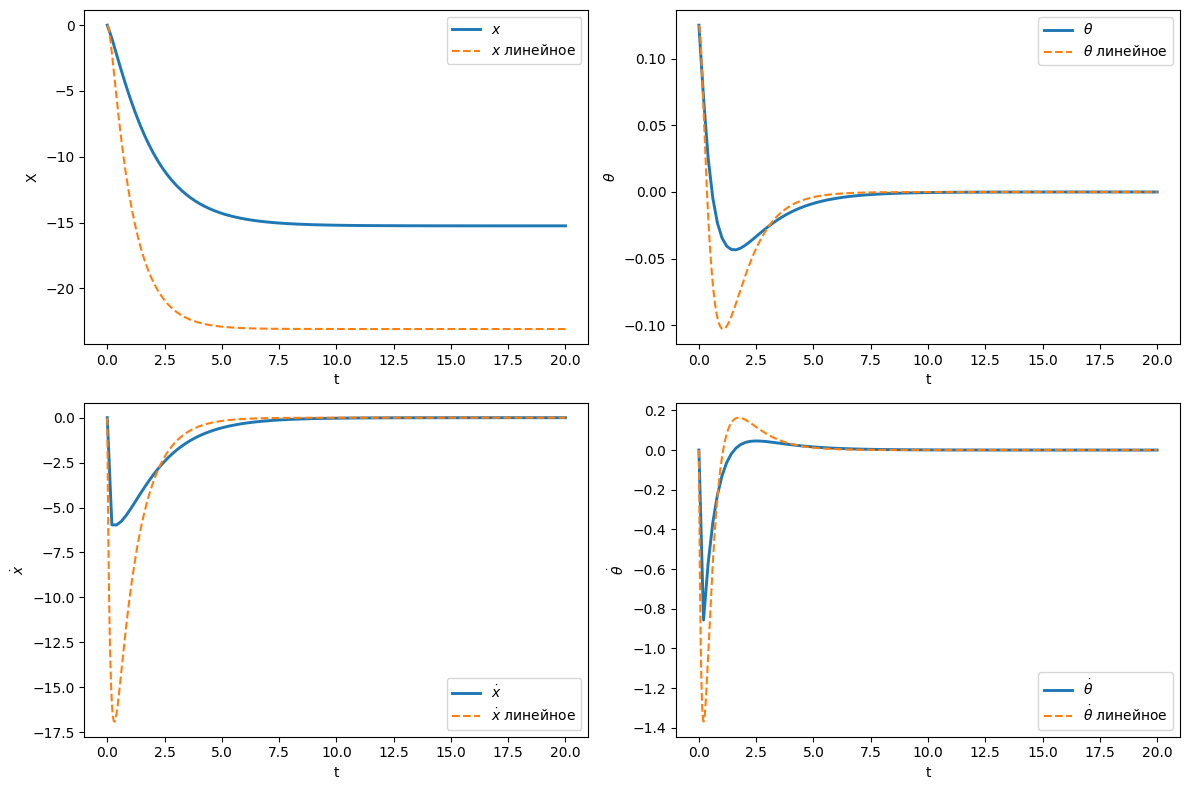

In [14]:
plt.figure(figsize=(12, 8))

# График x1 (позиция)
plt.subplot(2, 2, 1)
#plt.plot(t, x1, label='$x$', color='blue')
plt.plot(sol.t, sol.y[0], label='$x$', linewidth = 2.1)
plt.plot(t, x1, label='$x$ линейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel('X')
plt.grid(False)
plt.legend()

# График x2 (угол)
plt.subplot(2, 2, 2)
#plt.plot(t, x2, label=r'$\theta$', color='blue')
plt.plot(sol.t, sol.y[1]/np.pi, label=r'$\theta$', linewidth = 2.1)
plt.plot(t, x2/np.pi, label=r'$\theta$ линейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel(r'$\theta$')
plt.grid(False)
plt.legend()

# График x3 (скорость позиции)
plt.subplot(2, 2, 3)
#plt.plot(t, x3, label=r'$\dot{x}$', color='blue')
plt.plot(sol.t, sol.y[2], label=r'$\dot{x}$', linewidth = 2.1)
plt.plot(t, x3, label=r'$\dot{x}$ линейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel(r'$\dot{x}$')
plt.grid(False)
plt.legend()

# График x4 (угловая скорость)
plt.subplot(2, 2, 4)
#plt.plot(t, x4, label=r'$\dot{\theta}$', color='blue')
plt.plot(sol.t, sol.y[3], label=r'$\dot{\theta}$', linewidth = 2.1)
plt.plot(t, x4, label=r'$\dot{\theta}$ линейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel(r'$\dot{\theta}$')
plt.grid(False)
plt.legend()

plt.tight_layout()
plt.show()

По графикам видно, что при стабилизации маятника происходит постепенное смещение колеса от начального положения. Происходит это из-за отсутствия у системы асимптотической устойсивости, так как собственное число λ4 = 0 не сдвигалось в левую полуплоскость.

### 5 б

Теперь будем двигать не только положительное с.ч., но и с.ч. равное 0. Отсутствие собственного значения 0 должно привести к тому, что все переменные будут стремиться к нулю, а не к каким-то другим постоянным значениям. Предполагается, что система будет стремиться к состоянию равновесия асимптотически

#### Двигаем 2 с.ч. в -1

Рассмотрим сдвиг собственных чисел 0 и 0.521 в -1

In [6]:
def ackermann_control(A, B, desired_poles):
    n = len(desired_poles)
    A = A.astype(np.float64)
    B = B.astype(np.float64)
    
    C = np.hstack([np.linalg.matrix_power(A, i) @ B for i in range(n)])
    
    if np.linalg.matrix_rank(C) != n:
        raise ValueError("Система не управляема")
    
    poly_coeffs = np.poly(desired_poles)
    
    phi_A = np.zeros_like(A, dtype=np.float64)
    for power, coeff in enumerate(reversed(poly_coeffs)):
        phi_A += coeff * np.linalg.matrix_power(A, power)
    
    e = np.zeros((1, n), dtype=np.float64)
    e[0, -1] = 1
    
    K = -e @ np.linalg.inv(C) @ phi_A
    return K

desired_poles = [-1, -2.05945329, -7.50292918, -1]
K = ackermann_control(A, B, desired_poles)
print("Вектор управления K:", K)

Вектор управления K: [[   14.61634116 -1307.0431266     66.90876963  -633.36538228]]


In [50]:
Ac = A + B @ K
print(Ac)

[[ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 1.43741484e+01 -1.28532444e+03  5.83106913e+01 -6.22958018e+02]
 [ 1.57666472e+00 -1.39909072e+02  6.39591898e+00 -6.98730738e+01]]


In [51]:
eigenvalues, eigenvectors = np.linalg.eig(Ac)

print("Собственные числа:", eigenvalues)

Собственные числа: [-7.50292918 -2.05945329 -0.99999986 -1.00000014]


Для линейной системы

In [52]:
def model(x, t, A, B, K):
    u = np.dot(K, x)  # Управление по обратной связи
    dxdt = np.dot(A, x) + np.dot(B, u)
    return dxdt

t = np.linspace(0, 20, 1000)  # Временной интервал 0-8 секунд
x0 = [0, np.pi/8, 0, 0]         # Начальные условия [x1, x2, x3, x4]

solution = odeint(model, x0, t, args=(A, B, K))
x1 = solution[:, 0]  # Позиция (x)
x2 = solution[:, 1]  # Угол (θ)
x3 = solution[:, 2]  # Скорость позиции (ẋ)
x4 = solution[:, 3]  # Угловая скорость (θ̇)

Для нелинейной системы

In [53]:
g = 9.81
Kt = 1.726
Ks = 4.487
Bcq = 5.4
m =  0.56
l =  0.1778
Bp = 1.4
I = 0.89
M = 1.206

A1 = m + M
C1 = m * l
D1 = I + m * l**2
K1 = Kt*Ks + Bcq

def system(x, Y):
    y1, y2, y3, y4 = Y

    #u = u1 * y1 + u2 * y2 + u3 * y3 + u4 * y4
    f1 = -K1*y3 - C1 * y4**2 * np.sin(y2)
    f2 = -Bp*y4 + C1 * g * np.sin(y2)

    dydt = [
        y3,
        y4,
        (m * y4 * np.cos(y2) - m * y4**2 * np.sin(y2)) / (m + M) + Ac[2][0] * y1 + Ac[2][1] * y2 + Ac[2][2] * y3 + Ac[2][3] * y4,
        (m * l * ((m * y4 * np.cos(y2) - m * y4**2 * np.sin(y2)) / (m + M) + Ac[2][0] * y1 + Ac[2][1] * y2 + Ac[2][2] * y3 + Ac[2][3] * y4) * np.cos(y2) + m * g * l * np.sin(y2)) / (I + m * l**2) +  Ac[3][0] * y1 + Ac[3][1] * y2 + Ac[3][2] * y3 + Ac[3][3] * y4,
    ]

    return dydt


x0 = 0.0
xT = 20.0
y0 = [0.0, np.pi/8, 0.0, 0.0]
x_span = (x0, xT)  # интервал по x

# Временной интервал: от 0 до 8 секунд
t = np.linspace(0, 20, 1000)

# Интегрирование системы
sol = solve_ivp(system, x_span, y0, t_eval=np.linspace(x0, xT, 100))

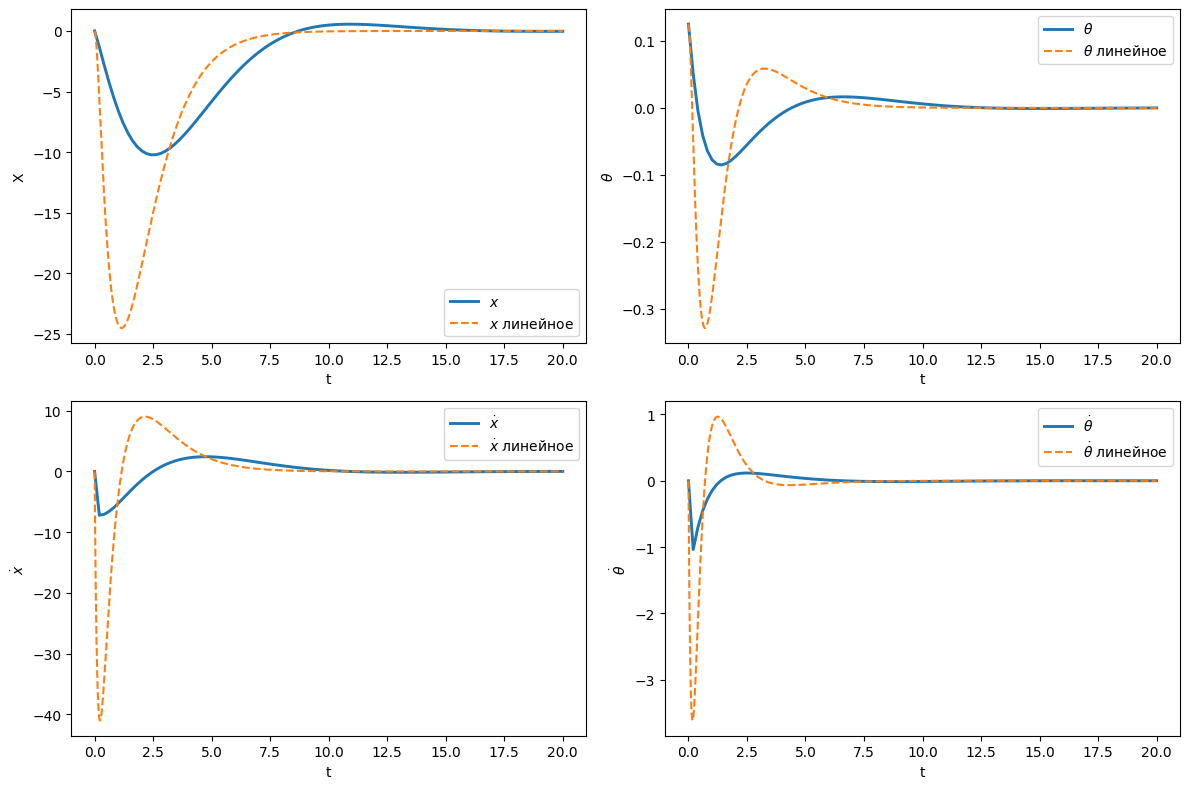

In [54]:
plt.figure(figsize=(12, 8))

# График x1 (позиция)
plt.subplot(2, 2, 1)
#plt.plot(t, x1, label='$x$', color='blue')
plt.plot(sol.t, sol.y[0], label='$x$', linewidth = 2.1)
plt.plot(t, x1, label='$x$ линейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel('X')
plt.grid(False)
plt.legend()

# График x2 (угол)
plt.subplot(2, 2, 2)
#plt.plot(t, x2, label=r'$\theta$', color='blue')
plt.plot(sol.t, sol.y[1]/np.pi, label=r'$\theta$', linewidth = 2.1)
plt.plot(t, x2/np.pi, label=r'$\theta$ линейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel(r'$\theta$')
plt.grid(False)
plt.legend()

# График x3 (скорость позиции)
plt.subplot(2, 2, 3)
#plt.plot(t, x3, label=r'$\dot{x}$', color='blue')
plt.plot(sol.t, sol.y[2], label=r'$\dot{x}$', linewidth = 2.1)
plt.plot(t, x3, label=r'$\dot{x}$ линейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel(r'$\dot{x}$')
plt.grid(False)
plt.legend()

# График x4 (угловая скорость)
plt.subplot(2, 2, 4)
#plt.plot(t, x4, label=r'$\dot{\theta}$', color='blue')
plt.plot(sol.t, sol.y[3], label=r'$\dot{\theta}$', linewidth = 2.1)
plt.plot(t, x4, label=r'$\dot{\theta}$ линейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel(r'$\dot{\theta}$')
plt.grid(False)
plt.legend()

plt.tight_layout()
plt.show()

 Судя по полученным графикам при использовании полученного регулятора система действительно стабилизируется вертикальном положении.

#### Двигаем 2 с.ч. в -1/2

Рассмотрим сдвиг собственных чисел 0 и 0.521 в -1/2

Мы ожидаем, что переходные процессы (возвращение к нулю) будут происходить медленнее, чем в предыдущем случае. Следовательно, время, необходимое для достижения устойчивого состояния, увеличится.

In [7]:
def ackermann_control(A, B, desired_poles):
    n = len(desired_poles)
    A = A.astype(np.float64)
    B = B.astype(np.float64)
    
    C = np.hstack([np.linalg.matrix_power(A, i) @ B for i in range(n)])
    
    if np.linalg.matrix_rank(C) != n:
        raise ValueError("Система не управляема")
    
    poly_coeffs = np.poly(desired_poles)
    
    phi_A = np.zeros_like(A, dtype=np.float64)
    for power, coeff in enumerate(reversed(poly_coeffs)):
        phi_A += coeff * np.linalg.matrix_power(A, power)
    
    e = np.zeros((1, n), dtype=np.float64)
    e[0, -1] = 1
    
    K = -e @ np.linalg.inv(C) @ phi_A
    return K

desired_poles = [-0.5, -2.05945329, -7.50292918, -0.5]
K = ackermann_control(A, B, desired_poles)
print("Вектор управления K:", K)

Вектор управления K: [[   3.65408529 -588.96847917   29.75590131 -285.37942428]]


In [157]:
Ac = A + B @ K
print(Ac)

[[ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 3.59353710e+00 -5.79148286e+02  2.17734460e+01 -2.80738187e+02]
 [ 3.94166180e-01 -6.24503598e+01  2.38823907e+00 -3.23358285e+01]]


Для линейной системы

In [158]:
def model(x, t, A, B, K):
    u = np.dot(K, x)  # Управление по обратной связи
    dxdt = np.dot(A, x) + np.dot(B, u)
    return dxdt

t = np.linspace(0, 20, 1000)  # Временной интервал 0-8 секунд
x0 = [0, np.pi/8, 0, 0]         # Начальные условия [x1, x2, x3, x4]

solution = odeint(model, x0, t, args=(A, B, K))
x1 = solution[:, 0]  # Позиция (x)
x2 = solution[:, 1]  # Угол (θ)
x3 = solution[:, 2]  # Скорость позиции (ẋ)
x4 = solution[:, 3]  # Угловая скорость (θ̇)

Для нелинейной системы

In [159]:
g = 9.81
Kt = 1.726
Ks = 4.487
Bcq = 5.4
m =  0.56
l =  0.1778
Bp = 1.4
I = 0.89
M = 1.206

A1 = m + M
C1 = m * l
D1 = I + m * l**2
K1 = Kt*Ks + Bcq

def system(x, Y):
    y1, y2, y3, y4 = Y

    #u = u1 * y1 + u2 * y2 + u3 * y3 + u4 * y4
    f1 = -K1*y3 - C1 * y4**2 * np.sin(y2)
    f2 = -Bp*y4 + C1 * g * np.sin(y2)

    dydt = [
        y3,
        y4,
        (m * y4 * np.cos(y2) - m * y4**2 * np.sin(y2)) / (m + M) + Ac[2][0] * y1 + Ac[2][1] * y2 + Ac[2][2] * y3 + Ac[2][3] * y4,
        (m * l * ((m * y4 * np.cos(y2) - m * y4**2 * np.sin(y2)) / (m + M) + Ac[2][0] * y1 + Ac[2][1] * y2 + Ac[2][2] * y3 + Ac[2][3] * y4) * np.cos(y2) + m * g * l * np.sin(y2)) / (I + m * l**2) +  Ac[3][0] * y1 + Ac[3][1] * y2 + Ac[3][2] * y3 + Ac[3][3] * y4,
    ]

    return dydt


x0 = 0.0
xT = 20.0
y0 = [0.0, np.pi/8, 0.0, 0.0]
x_span = (x0, xT)  # интервал по x

# Временной интервал: от 0 до 8 секунд
t = np.linspace(0, 20, 1000)

# Интегрирование системы
sol = solve_ivp(system, x_span, y0, t_eval=np.linspace(x0, xT, 100))

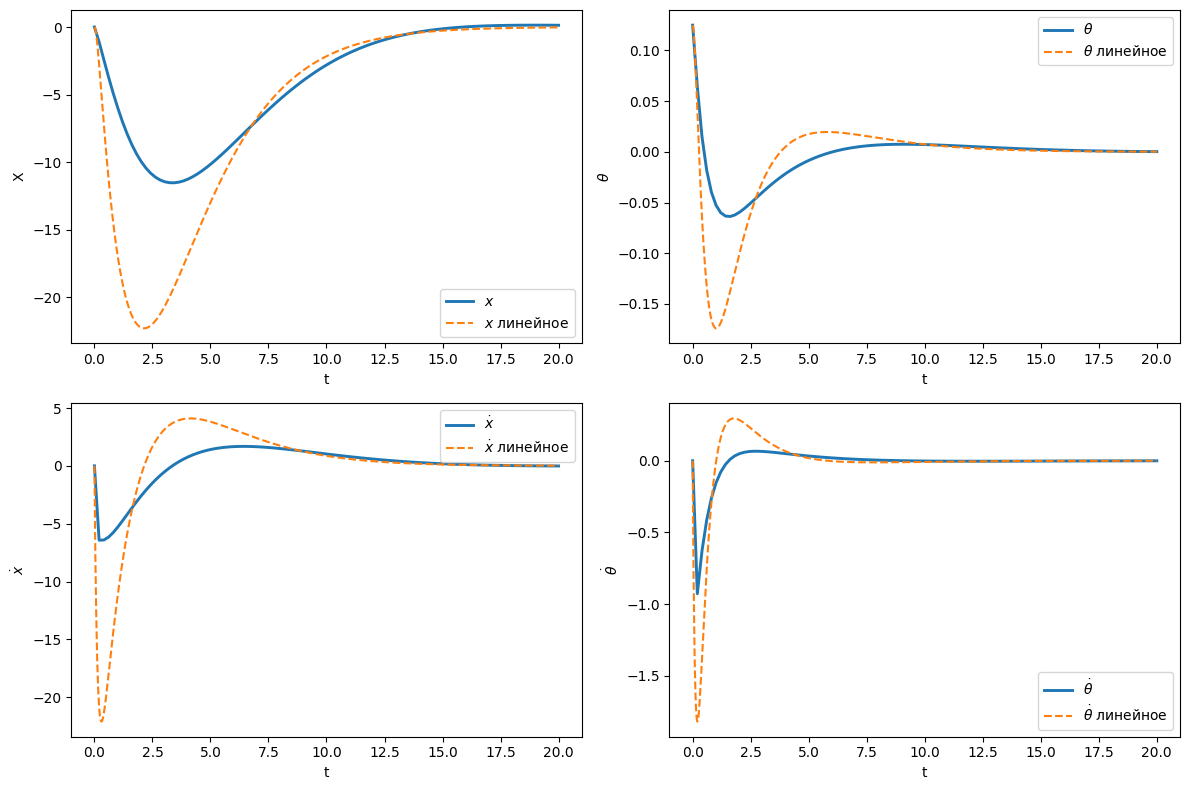

In [160]:
plt.figure(figsize=(12, 8))

# График x1 (позиция)
plt.subplot(2, 2, 1)
#plt.plot(t, x1, label='$x$', color='blue')
plt.plot(sol.t, sol.y[0], label='$x$', linewidth = 2.1)
plt.plot(t, x1, label='$x$ линейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel('X')
plt.grid(False)
plt.legend()

# График x2 (угол)
plt.subplot(2, 2, 2)
#plt.plot(t, x2, label=r'$\theta$', color='blue')
plt.plot(sol.t, sol.y[1]/np.pi, label=r'$\theta$', linewidth = 2.1)
plt.plot(t, x2/np.pi, label=r'$\theta$ линейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel(r'$\theta$')
plt.grid(False)
plt.legend()

# График x3 (скорость позиции)
plt.subplot(2, 2, 3)
#plt.plot(t, x3, label=r'$\dot{x}$', color='blue')
plt.plot(sol.t, sol.y[2], label=r'$\dot{x}$', linewidth = 2.1)
plt.plot(t, x3, label=r'$\dot{x}$ линейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel(r'$\dot{x}$')
plt.grid(False)
plt.legend()

# График x4 (угловая скорость)
plt.subplot(2, 2, 4)
#plt.plot(t, x4, label=r'$\dot{\theta}$', color='blue')
plt.plot(sol.t, sol.y[3], label=r'$\dot{\theta}$', linewidth = 2.1)
plt.plot(t, x4, label=r'$\dot{\theta}$ линейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel(r'$\dot{\theta}$')
plt.grid(False)
plt.legend()

plt.tight_layout()
plt.show()

Уменьшение абсолютной величины собственных значений с -1 до -1/2 действительно привело к замедлению затухания, как и ожидалось.

#### Двигаем 2 с.ч. в -10

Рассмотрим сдвиг собственных чисел 0 и 0.521 в -10

Мы ожидаем, что возвращение к нулю будет происходить быстрее, чем в предыдущих случаях. Следовательно, время, необходимое для достижения устойчивого состояния, уменьшится.

In [4]:
def ackermann_control(A, B, desired_poles):
    n = len(desired_poles)
    A = A.astype(np.float64)
    B = B.astype(np.float64)
    
    C = np.hstack([np.linalg.matrix_power(A, i) @ B for i in range(n)])
    
    if np.linalg.matrix_rank(C) != n:
        raise ValueError("Система не управляема")
    
    poly_coeffs = np.poly(desired_poles)
    
    phi_A = np.zeros_like(A, dtype=np.float64)
    for power, coeff in enumerate(reversed(poly_coeffs)):
        phi_A += coeff * np.linalg.matrix_power(A, power)
    
    e = np.zeros((1, n), dtype=np.float64)
    e[0, -1] = 1
    
    K = -e @ np.linalg.inv(C) @ phi_A
    return K

desired_poles = [-10, -2.05945329, -7.50292918, -10]
K = ackermann_control(A, B, desired_poles)
print("Вектор управления K:", K)

Вектор управления K: [[  1461.63411568 -62535.93845169   3303.69225087 -30309.36407471]]


In [5]:
Ac = A + B @ K
print(Ac)

[[ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 1.43741484e+03 -6.14996570e+04  3.24146067e+03 -2.98072254e+04]
 [ 1.57666472e+02 -6.74467001e+03  3.55547753e+02 -3.27102305e+03]]


Для линейной системы

In [21]:
def model(x, t, A, B, K, u_history):
    u = np.dot(K, x)  # Управление по обратной связи
    u_history.append(u)
    dxdt = np.dot(A, x) + np.dot(B, u)
    return dxdt

t = np.linspace(0, 20, 1000)  # Временной интервал 0-8 секунд
x0 = [0, np.pi/8, 0, 0]         # Начальные условия [x1, x2, x3, x4]

u_history = []

solution = odeint(model, x0, t, args=(A, B, K, u_history))
x1 = solution[:, 0]  # Позиция (x)
x2 = solution[:, 1]  # Угол (θ)
x3 = solution[:, 2]  # Скорость позиции (ẋ)
x4 = solution[:, 3]  # Угловая скорость (θ̇)
u_values = np.array(u_history)

Для нелинейной системы

In [24]:
g = 9.81
Kt = 1.726
Ks = 4.487
Bcq = 5.4
m =  0.56
l =  0.1778
Bp = 1.4
I = 0.89
M = 1.206

A1 = m + M
C1 = m * l
D1 = I + m * l**2
K1 = Kt*Ks + Bcq

def systemLinal(x, Y):
    x, fi, y1, y2 = Y
    tu = 0
    return [Ac[0][0] * x + Ac[0][1] * fi + y1, Ac[1][0] * x + Ac[1][1] * fi + y2, Ac[2][0] * x + Ac[2][1]*fi + Ac[2][2] * y1 + Ac[2][3] * y2, Ac[3][0] * x + Ac[3][1] *  fi + Ac[3][2] * y1 + Ac[3][3] * y2]

def system(x, Y):
    y1, y2, y3, y4 = Y

    #u = u1 * y1 + u2 * y2 + u3 * y3 + u4 * y4
    f1 = -K1*y3 - C1 * y4**2 * np.sin(y2)
    f2 = -Bp*y4 + C1 * g * np.sin(y2)

    dydt = [
        y3,
        y4,
        (m * y4 * np.cos(y2) - m * y4**2 * np.sin(y2)) / (m + M) + Ac[2][0] * y1 + Ac[2][1] * y2 + Ac[2][2] * y3 + Ac[2][3] * y4,
        (m * l * ((m * y4 * np.cos(y2) - m * y4**2 * np.sin(y2)) / (m + M) + Ac[2][0] * y1 + Ac[2][1] * y2 + Ac[2][2] * y3 + Ac[2][3] * y4) * np.cos(y2) + m * g * l * np.sin(y2)) / (I + m * l**2) +  Ac[3][0] * y1 + Ac[3][1] * y2 + Ac[3][2] * y3 + Ac[3][3] * y4,
    ]

    return dydt


x0 = 0.0
xT = 10.0
y0 = [0.0, np.pi/8, 0.0, 0.0]
x_span = (x0, xT)  # интервал по x

# Временной интервал: от 0 до 8 секунд
t = np.linspace(0, 20, 1000)

# Интегрирование системы
sol = solve_ivp(system, x_span, y0, t_eval=np.linspace(x0, xT, 100))
solLineal = solve_ivp(systemLinal, x_span, y0, t_eval=np.linspace(x0, xT, 100))
u_nonlin = K[0][0]*sol.y[0] + K[0][1]*sol.y[1] + K[0][2]*sol.y[2] + K[0][3]*sol.y[3]
u_lin = K[0][0]*solLineal.y[0] + K[0][1]*solLineal.y[1] + K[0][2]*solLineal.y[2] + K[0][3]*solLineal.y[3]

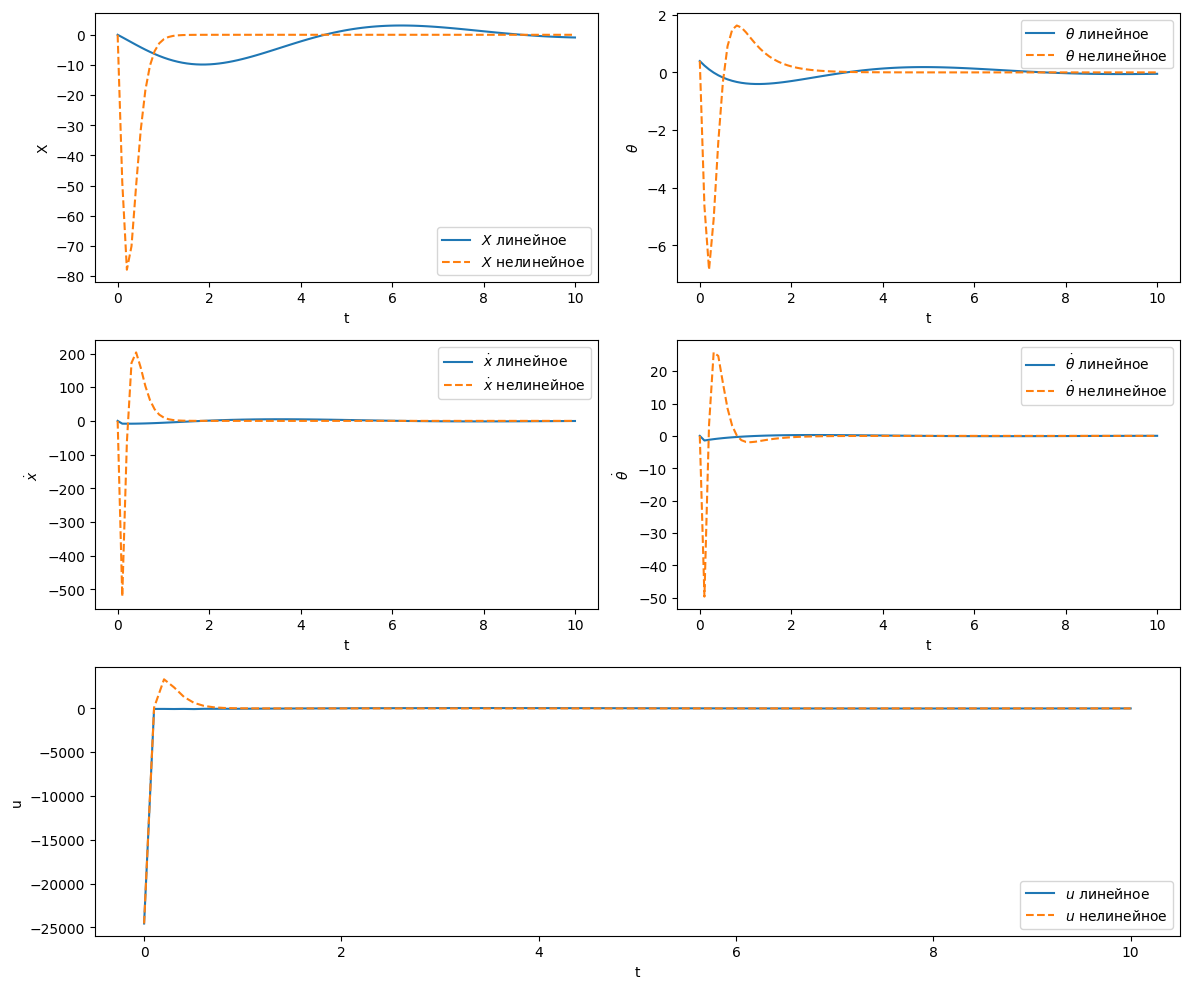

In [ ]:
# plt.figure(figsize=(12, 10))

# # График x1 (позиция)
# plt.subplot(3, 2, 1)
# #plt.plot(t, x1, label='$x$', color='blue')
# plt.plot(sol.t, sol.y[0], label='$x$', linewidth = 2.1)
# plt.plot(t, x1, label='$x$ линейное', linestyle = '--')
# plt.xlabel('t')
# plt.ylabel('X')
# plt.grid(False)
# plt.legend()

# # График x2 (угол)
# plt.subplot(3, 2, 2)
# #plt.plot(t, x2, label=r'$\theta$', color='blue')
# plt.plot(sol.t, sol.y[1]/np.pi, label=r'$\theta$', linewidth = 2.1)
# plt.plot(t, x2/np.pi, label=r'$\theta$ линейное', linestyle = '--')
# plt.xlabel('t')
# plt.ylabel(r'$\theta$')
# plt.grid(False)
# plt.legend()

# # График x3 (скорость позиции)
# plt.subplot(3, 2, 3)
# #plt.plot(t, x3, label=r'$\dot{x}$', color='blue')
# plt.plot(sol.t, sol.y[2], label=r'$\dot{x}$', linewidth = 2.1)
# plt.plot(t, x3, label=r'$\dot{x}$ линейное', linestyle = '--')
# plt.xlabel('t')
# plt.ylabel(r'$\dot{x}$')
# plt.grid(False)
# plt.legend()

# # График x4 (угловая скорость)
# plt.subplot(3, 2, 4)
# #plt.plot(t, x4, label=r'$\dot{\theta}$', color='blue')
# plt.plot(sol.t, sol.y[3], label=r'$\dot{\theta}$', linewidth = 2.1)
# plt.plot(t, x4, label=r'$\dot{\theta}$ линейное', linestyle = '--')
# plt.xlabel('t')
# plt.ylabel(r'$\dot{\theta}$')
# plt.grid(False)
# plt.legend()

# # График управления (занимает ширину двух графиков)
# plt.subplot(3, 1, 3) # 3 строки, 1 столбец, позиция 3 (занимает всю третью строку)
# plt.plot(t, u_values, label='u линейное')
# plt.plot(sol.t, u_nonlin, label='u нелинейное', linestyle = '--')
# plt.xlabel('t')
# plt.ylabel('u')
# plt.legend()
# plt.grid(False)

# plt.tight_layout()
# plt.show()

plt.figure(figsize=(12, 10))  # Увеличиваем высоту фигуры, чтобы вместить 5 графиков

# График x1 (позиция)
plt.subplot(3, 2, 1) # 3 строки, 2 столбца, позиция 1
plt.plot(sol.t, sol.y[0], label='$X$ линейное')
plt.plot(solLineal.t, solLineal.y[0], label='$X$ нелинейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel('X')
plt.grid(False)
plt.legend()

# График x2 (угол)
plt.subplot(3, 2, 2) # 3 строки, 2 столбца, позиция 2
plt.plot(sol.t, sol.y[1], label=r'$\theta$ линейное')
plt.plot(solLineal.t, solLineal.y[1], label=r'$\theta$ нелинейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel(r'$\theta$')
plt.grid(False)
plt.legend()

# График x3 (скорость позиции)
plt.subplot(3, 2, 3) # 3 строки, 2 столбца, позиция 3
plt.plot(sol.t, sol.y[2], label=r'$\dot{x}$ линейное')
plt.plot(solLineal.t, solLineal.y[2],label=r'$\dot{x}$ нелинейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel(r'$\dot{x}$')
plt.grid(False)
plt.legend()

# График x4 (угловая скорость)
plt.subplot(3, 2, 4) # 3 строки, 2 столбца, позиция 4
plt.plot(sol.t, sol.y[3],  label=r'$\dot{\theta}$ линейное')
plt.plot(solLineal.t, solLineal.y[3], label=r'$\dot{\theta}$ нелинейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel(r'$\dot{\theta}$')
plt.grid(False)
plt.legend()

# График управления (занимает ширину двух графиков)
plt.subplot(3, 1, 3) # 3 строки, 1 столбец, позиция 3 (занимает всю третью строку)
plt.plot(sol.t, u_nonlin, label='$u$ линейное')
plt.plot(solLineal.t, u_lin, label='$u$ нелинейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel('u')
plt.legend()
plt.grid(False)

plt.tight_layout()
plt.show()

Как мы видим, более отрицательные собственные значения привели к более быстрому затуханию, как и предполагалось. 

### 5 в

Теперь будем двигать собственные числа 0 и 0.521 в комплексно сопряженные числа в левой полуплоскости комплексной плоскости. Затухания должны иметь колебательный характер 

#### Двигаем 2 с.ч. в -2 +- 3i

Рассмотрим сдвиг собственных чисел 0 и 0.521 в -2 +- 3i

In [15]:
def ackermann_control(A, B, desired_poles):
    n = len(desired_poles)
    A = A.astype(np.float64)
    B = B.astype(np.float64)
    
    C = np.hstack([np.linalg.matrix_power(A, i) @ B for i in range(n)])
    
    if np.linalg.matrix_rank(C) != n:
        raise ValueError("Система не управляема")
    
    poly_coeffs = np.poly(desired_poles)
    
    phi_A = np.zeros_like(A, dtype=np.float64)
    for power, coeff in enumerate(reversed(poly_coeffs)):
        phi_A += coeff * np.linalg.matrix_power(A, power)
    
    e = np.zeros((1, n), dtype=np.float64)
    e[0, -1] = 1
    
    K = -e @ np.linalg.inv(C) @ phi_A
    return K

desired_poles = [-2+3j, -2.05945329, -7.50292918, -2-3j]
K = ackermann_control(A, B, desired_poles)
print("Вектор управления K:", K)

Вектор управления K: [[  190.01243504 -8675.207539     456.58683891 -4204.52607265]]


In [16]:
Ac = A + B @ K
print(Ac)

[[ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 1.86863929e+02 -8.53139837e+03  4.41531795e+02 -4.13494458e+03]
 [ 2.04966414e+01 -9.34712967e+02  4.84304923e+01 -4.55094177e+02]]


In [17]:
eigenvalues, eigenvectors = np.linalg.eig(Ac)

print("Собственные числа:", eigenvalues)

Собственные числа: [-7.50292918+0.j -2.        +3.j -2.        -3.j -2.05945329+0.j]


Для линейной системы

In [18]:
def model(x, t, A, B, K):
    u = np.dot(K, x)  # Управление по обратной связи
    dxdt = np.dot(A, x) + np.dot(B, u)
    return dxdt

t = np.linspace(0, 8, 1000)  # Временной интервал 0-8 секунд
x0 = [0, 0.15, 0, 0]         # Начальные условия [x1, x2, x3, x4]

solution = odeint(model, x0, t, args=(A, B, K))
x1 = solution[:, 0]  # Позиция (x)
x2 = solution[:, 1]  # Угол (θ)
x3 = solution[:, 2]  # Скорость позиции (ẋ)
x4 = solution[:, 3]  # Угловая скорость (θ̇)

Для нелинейной системы

In [19]:
g = 9.81
Kt = 1.726
Ks = 4.487
Bcq = 5.4
m =  0.56
l =  0.1778
Bp = 1.4
I = 0.89
M = 1.206

A1 = m + M
C1 = m * l
D1 = I + m * l**2
K1 = Kt*Ks + Bcq

def system(x, Y):
    y1, y2, y3, y4 = Y

    #u = u1 * y1 + u2 * y2 + u3 * y3 + u4 * y4
    f1 = -K1*y3 - C1 * y4**2 * np.sin(y2)
    f2 = -Bp*y4 + C1 * g * np.sin(y2)

    dydt = [
        y3,
        y4,
        (m * y4 * np.cos(y2) - m * y4**2 * np.sin(y2)) / (m + M) + Ac[2][0] * y1 + Ac[2][1] * y2 + Ac[2][2] * y3 + Ac[2][3] * y4,
        (m * l * ((m * y4 * np.cos(y2) - m * y4**2 * np.sin(y2)) / (m + M) + Ac[2][0] * y1 + Ac[2][1] * y2 + Ac[2][2] * y3 + Ac[2][3] * y4) * np.cos(y2) + m * g * l * np.sin(y2)) / (I + m * l**2) +  Ac[3][0] * y1 + Ac[3][1] * y2 + Ac[3][2] * y3 + Ac[3][3] * y4,
    ]

    return dydt


x0 = 0.0
xT = 20.0
y0 = [0.0, np.pi/8, 0.0, 0.0]
x_span = (x0, xT)  # интервал по x

# Временной интервал: от 0 до 8 секунд
t = np.linspace(0, 20, 1000)

# Интегрирование системы
sol = solve_ivp(system, x_span, y0, t_eval=np.linspace(x0, xT, 100))

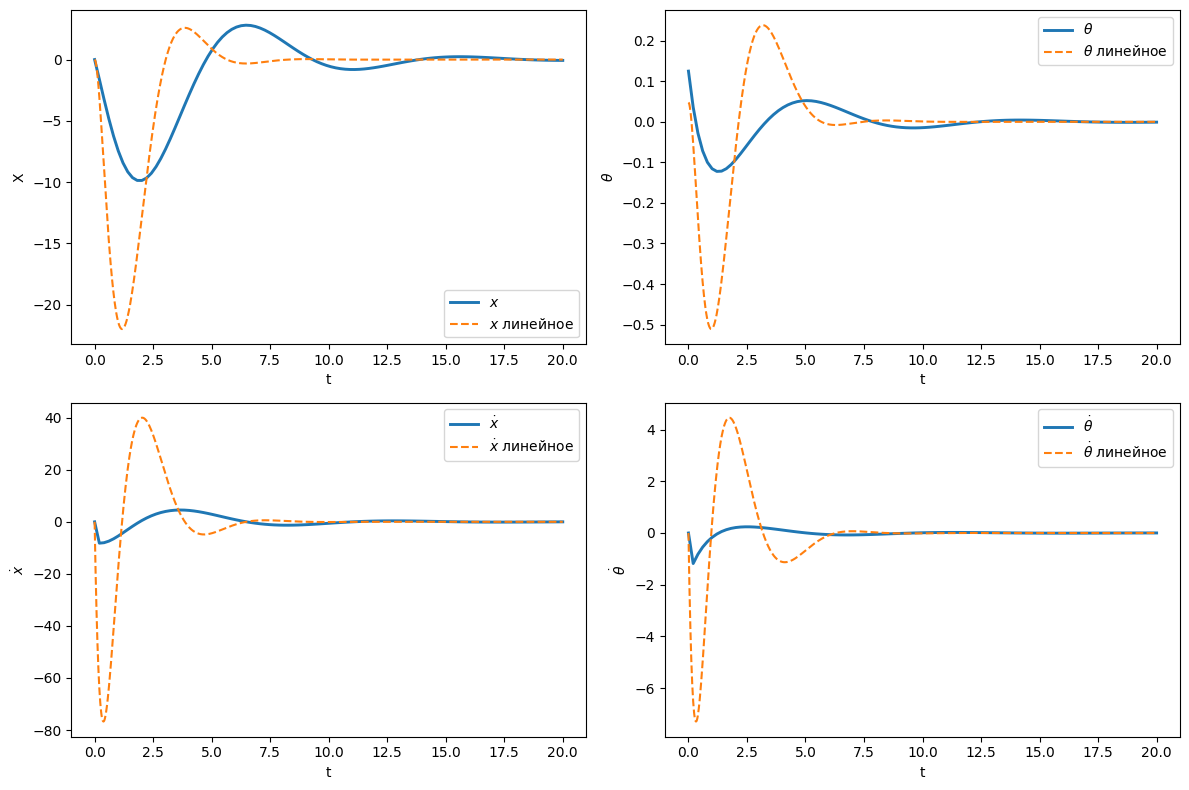

In [20]:
plt.figure(figsize=(12, 8))

# График x1 (позиция)
plt.subplot(2, 2, 1)
#plt.plot(t, x1, label='$x$', color='blue')
plt.plot(sol.t, sol.y[0], label='$x$', linewidth = 2.1)
plt.plot(t, x1, label='$x$ линейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel('X')
plt.grid(False)
plt.legend()

# График x2 (угол)
plt.subplot(2, 2, 2)
#plt.plot(t, x2, label=r'$\theta$', color='blue')
plt.plot(sol.t, sol.y[1]/np.pi, label=r'$\theta$', linewidth = 2.1)
plt.plot(t, x2/np.pi, label=r'$\theta$ линейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel(r'$\theta$')
plt.grid(False)
plt.legend()

# График x3 (скорость позиции)
plt.subplot(2, 2, 3)
#plt.plot(t, x3, label=r'$\dot{x}$', color='blue')
plt.plot(sol.t, sol.y[2], label=r'$\dot{x}$', linewidth = 2.1)
plt.plot(t, x3, label=r'$\dot{x}$ линейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel(r'$\dot{x}$')
plt.grid(False)
plt.legend()

# График x4 (угловая скорость)
plt.subplot(2, 2, 4)
#plt.plot(t, x4, label=r'$\dot{\theta}$', color='blue')
plt.plot(sol.t, sol.y[3], label=r'$\dot{\theta}$', linewidth = 2.1)
plt.plot(t, x4, label=r'$\dot{\theta}$ линейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel(r'$\dot{\theta}$')
plt.grid(False)
plt.legend()

plt.tight_layout()
plt.show()

Судя по полученным графикам при использовании полученного регулятора система действительно стабилизируется в вертикальном положении. При этом появились заметные колебания всех траекторий.

#### Двигаем 2 с.ч. в -1/2 +- 2i

Рассмотрим сдвиг собственных чисел 0 и 0.521 в -1/2 +- 2i

Мы уменьшили действительную часть комплексно-сопряженных собственных чисел. Ожидаем увидеть более медленное затухание колебаний, а также увеличение времени переходного процесса.

In [14]:
def ackermann_control(A, B, desired_poles):
    n = len(desired_poles)
    A = A.astype(np.float64)
    B = B.astype(np.float64)
    
    C = np.hstack([np.linalg.matrix_power(A, i) @ B for i in range(n)])
    
    if np.linalg.matrix_rank(C) != n:
        raise ValueError("Система не управляема")
    
    poly_coeffs = np.poly(desired_poles)
    
    phi_A = np.zeros_like(A, dtype=np.float64)
    for power, coeff in enumerate(reversed(poly_coeffs)):
        phi_A += coeff * np.linalg.matrix_power(A, power)
    
    e = np.zeros((1, n), dtype=np.float64)
    e[0, -1] = 1
    
    K = -e @ np.linalg.inv(C) @ phi_A
    return K

desired_poles = [-1/2+1j, -2.05945329, -7.50292918, -1/2-1j]
K = ackermann_control(A, B, desired_poles)
print("Вектор управления K:", K)

Вектор управления K: [[   18.27042645 -1153.92229989    59.79136156  -559.2069266 ]]


In [15]:
Ac = A + B @ K
print(Ac)

[[ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 1.79676855e+01 -1.13474082e+03  5.13112187e+01 -5.50028368e+02]
 [ 1.97083090e+00 -1.23391928e+02  5.62816417e+00 -6.18736012e+01]]


Для линейной системы

In [6]:
def model(x, t, A, B, K):
    u = np.dot(K, x)  # Управление по обратной связи
    dxdt = np.dot(A, x) + np.dot(B, u)
    return dxdt

t = np.linspace(0, 8, 1000)  # Временной интервал 0-8 секунд
x0 = [0, 0.15, 0, 0]         # Начальные условия [x1, x2, x3, x4]

solution = odeint(model, x0, t, args=(A, B, K))
x1 = solution[:, 0]  # Позиция (x)
x2 = solution[:, 1]  # Угол (θ)
x3 = solution[:, 2]  # Скорость позиции (ẋ)
x4 = solution[:, 3]  # Угловая скорость (θ̇)

Для нелинейной системы

In [16]:
g = 9.81
Kt = 1.726
Ks = 4.487
Bcq = 5.4
m =  0.56
l =  0.1778
Bp = 1.4
I = 0.89
M = 1.206

A1 = m + M
C1 = m * l
D1 = I + m * l**2
K1 = Kt*Ks + Bcq


def systemLinal(x, Y):
    x, fi, y1, y2 = Y
    tu = 0
    return [Ac[0][0] * x + Ac[0][1] * fi + y1, Ac[1][0] * x + Ac[1][1] * fi + y2, Ac[2][0] * x + Ac[2][1]*fi + Ac[2][2] * y1 + Ac[2][3] * y2, Ac[3][0] * x + Ac[3][1] *  fi + Ac[3][2] * y1 + Ac[3][3] * y2]

def system(x, Y):
    y1, y2, y3, y4 = Y

    #u = u1 * y1 + u2 * y2 + u3 * y3 + u4 * y4
    f1 = -K1*y3 - C1 * y4**2 * np.sin(y2)
    f2 = -Bp*y4 + C1 * g * np.sin(y2)

    dydt = [
        y3,
        y4,
        (m * y4 * np.cos(y2) - m * y4**2 * np.sin(y2)) / (m + M) + Ac[2][0] * y1 + Ac[2][1] * y2 + Ac[2][2] * y3 + Ac[2][3] * y4,
        (m * l * ((m * y4 * np.cos(y2) - m * y4**2 * np.sin(y2)) / (m + M) + Ac[2][0] * y1 + Ac[2][1] * y2 + Ac[2][2] * y3 + Ac[2][3] * y4) * np.cos(y2) + m * g * l * np.sin(y2)) / (I + m * l**2) +  Ac[3][0] * y1 + Ac[3][1] * y2 + Ac[3][2] * y3 + Ac[3][3] * y4,
    ]

    return dydt


x0 = 0.0
xT = 20.0
y0 = [0.0, 0.15, 0.0, 0.0]
x_span = (x0, xT)  # интервал по x

# Временной интервал: от 0 до 8 секунд
t = np.linspace(0, 20, 1000)

# Интегрирование системы
sol = solve_ivp(system, x_span, y0, t_eval=np.linspace(x0, xT, 100))
solLineal = solve_ivp(systemLinal, x_span, y0, t_eval=np.linspace(x0, xT, 100))

u_nonlin = K[0][0]*sol.y[0] + K[0][1]*sol.y[1] + K[0][2]*sol.y[2] + K[0][3]*sol.y[3]
u_lin = K[0][0]*solLineal.y[0] + K[0][1]*solLineal.y[1] + K[0][2]*solLineal.y[2] + K[0][3]*solLineal.y[3]

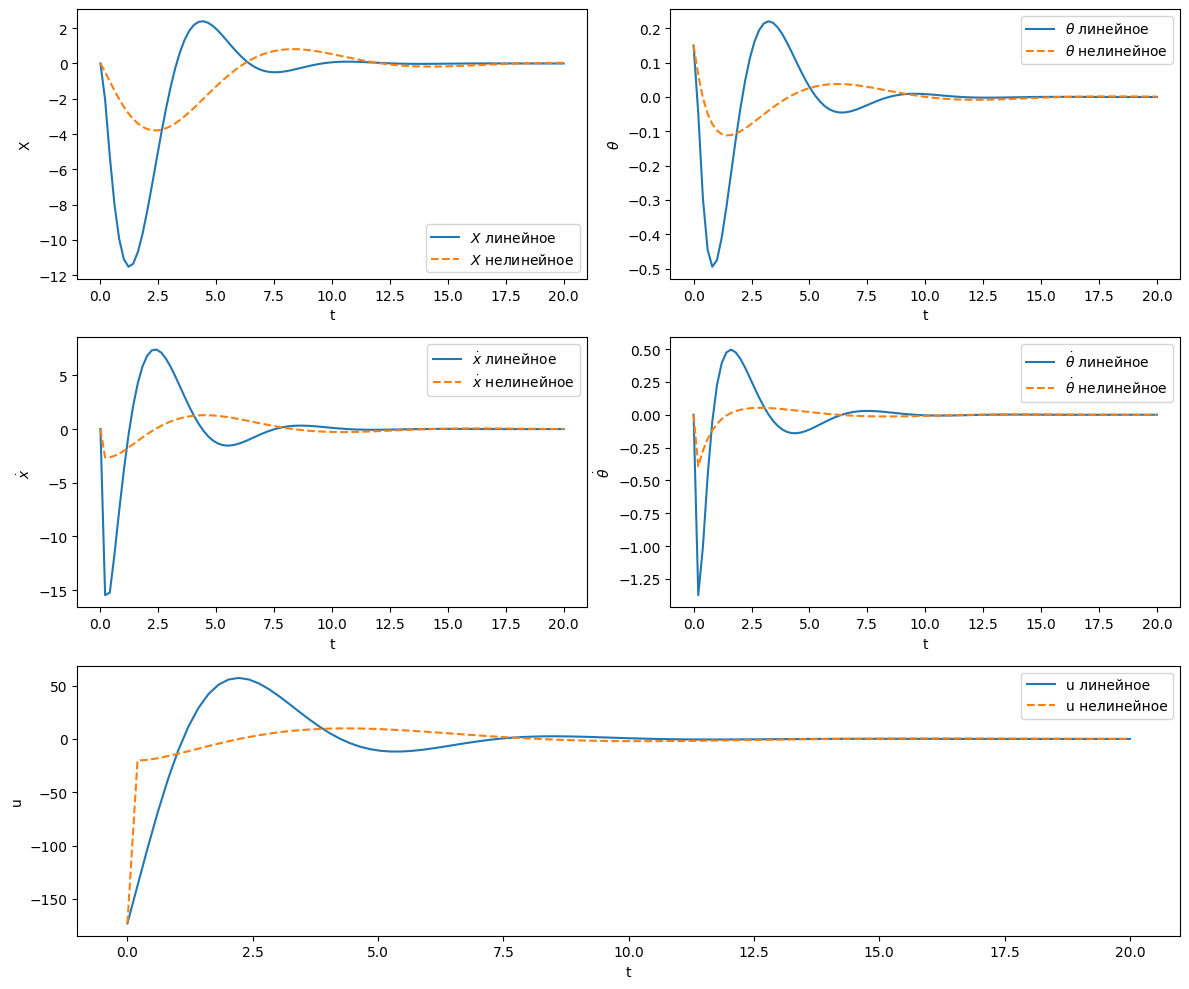

In [17]:
plt.figure(figsize=(12, 10))  # Увеличиваем высоту фигуры, чтобы вместить 5 графиков

# График x1 (позиция)
plt.subplot(3, 2, 1) # 3 строки, 2 столбца, позиция 1
plt.plot(solLineal.t, solLineal.y[0], label='$X$ линейное')
plt.plot(sol.t, sol.y[0], label='$X$ нелинейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel('X')
plt.grid(False)
plt.legend()

# График x2 (угол)
plt.subplot(3, 2, 2) # 3 строки, 2 столбца, позиция 2
plt.plot(solLineal.t, solLineal.y[1], label=r'$\theta$ линейное')
plt.plot(sol.t, sol.y[1], label=r'$\theta$ нелинейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel(r'$\theta$')
plt.grid(False)
plt.legend()

# График x3 (скорость позиции)
plt.subplot(3, 2, 3) # 3 строки, 2 столбца, позиция 3
plt.plot(solLineal.t, solLineal.y[2], label=r'$\dot{x}$ линейное')
plt.plot(sol.t, sol.y[2], label=r'$\dot{x}$ нелинейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel(r'$\dot{x}$')
plt.grid(False)
plt.legend()

# График x4 (угловая скорость)
plt.subplot(3, 2, 4) # 3 строки, 2 столбца, позиция 4
plt.plot(solLineal.t, solLineal.y[3], label=r'$\dot{\theta}$ линейное')
plt.plot(sol.t, sol.y[3], label=r'$\dot{\theta}$ нелинейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel(r'$\dot{\theta}$')
plt.grid(False)
plt.legend()

# График управления (занимает ширину двух графиков)
plt.subplot(3, 1, 3) # 3 строки, 1 столбец, позиция 3 (занимает всю третью строку)
plt.plot(solLineal.t, u_lin, label='u линейное')
plt.plot(sol.t, u_nonlin, label='u нелинейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel('u')
plt.legend()
plt.grid(False)

plt.tight_layout()
plt.show()

На графиках видно, что колебания затухают медленнее. Время переходного процесса заметно увеличивается.

#### Двигаем 2 с.ч. в -1/2 +- 8i

Рассмотрим сдвиг собственных чисел 0 и 0.521 в -1/2 +- 8i

Мы увеличили мнимую часть комплексно-сопряженных собственных чисел. Ожидаем увидеть увеличение частоты колебаний по сравнению с предыдущим случаем. 

In [91]:
def ackermann_control(A, B, desired_poles):
    n = len(desired_poles)
    A = A.astype(np.float64)
    B = B.astype(np.float64)
    
    C = np.hstack([np.linalg.matrix_power(A, i) @ B for i in range(n)])
    
    if np.linalg.matrix_rank(C) != n:
        raise ValueError("Система не управляема")
    
    poly_coeffs = np.poly(desired_poles)
    
    phi_A = np.zeros_like(A, dtype=np.float64)
    for power, coeff in enumerate(reversed(poly_coeffs)):
        phi_A += coeff * np.linalg.matrix_power(A, power)
    
    e = np.zeros((1, n), dtype=np.float64)
    e[0, -1] = 1
    
    K = -e @ np.linalg.inv(C) @ phi_A
    return K

desired_poles = [-1/2+8j, -2.05945329, -7.50292918, -1/2-8j]
K = ackermann_control(A, B, desired_poles)
print("Вектор управления K:", K)

Вектор управления K: [[   939.09991933 -36746.01300511   1952.02535742 -17810.33957275]]


In [92]:
Ac = A + B @ K
print(Ac)

[[ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [ 9.23539034e+02 -3.61370706e+04  1.91219090e+03 -1.75153097e+04]
 [ 1.01300708e+02 -3.96271075e+03  2.09743445e+02 -1.92275328e+03]]


Для линейной системы

In [93]:
def model(x, t, A, B, K):
    u = np.dot(K, x)  # Управление по обратной связи
    dxdt = np.dot(A, x) + np.dot(B, u)
    return dxdt

t = np.linspace(0, 8, 1000)  # Временной интервал 0-8 секунд
x0 = [0, 0.15, 0, 0]         # Начальные условия [x1, x2, x3, x4]

solution = odeint(model, x0, t, args=(A, B, K))
x1 = solution[:, 0]  # Позиция (x)
x2 = solution[:, 1]  # Угол (θ)
x3 = solution[:, 2]  # Скорость позиции (ẋ)
x4 = solution[:, 3]  # Угловая скорость (θ̇)

Для нелинейной системы

In [94]:
g = 9.81
Kt = 1.726
Ks = 4.487
Bcq = 5.4
m =  0.56
l =  0.1778
Bp = 1.4
I = 0.89
M = 1.206

A1 = m + M
C1 = m * l
D1 = I + m * l**2
K1 = Kt*Ks + Bcq

def system(x, Y):
    y1, y2, y3, y4 = Y

    #u = u1 * y1 + u2 * y2 + u3 * y3 + u4 * y4
    f1 = -K1*y3 - C1 * y4**2 * np.sin(y2)
    f2 = -Bp*y4 + C1 * g * np.sin(y2)

    dydt = [
        y3,
        y4,
        (m * y4 * np.cos(y2) - m * y4**2 * np.sin(y2)) / (m + M) + Ac[2][0] * y1 + Ac[2][1] * y2 + Ac[2][2] * y3 + Ac[2][3] * y4,
        (m * l * ((m * y4 * np.cos(y2) - m * y4**2 * np.sin(y2)) / (m + M) + Ac[2][0] * y1 + Ac[2][1] * y2 + Ac[2][2] * y3 + Ac[2][3] * y4) * np.cos(y2) + m * g * l * np.sin(y2)) / (I + m * l**2) +  Ac[3][0] * y1 + Ac[3][1] * y2 + Ac[3][2] * y3 + Ac[3][3] * y4,
    ]

    return dydt


x0 = 0.0
xT = 20.0
y0 = [0.0, np.pi/8, 0.0, 0.0]
x_span = (x0, xT)  # интервал по x

# Временной интервал: от 0 до 8 секунд
t = np.linspace(0, 20, 1000)

# Интегрирование системы
sol = solve_ivp(system, x_span, y0, t_eval=np.linspace(x0, xT, 100))

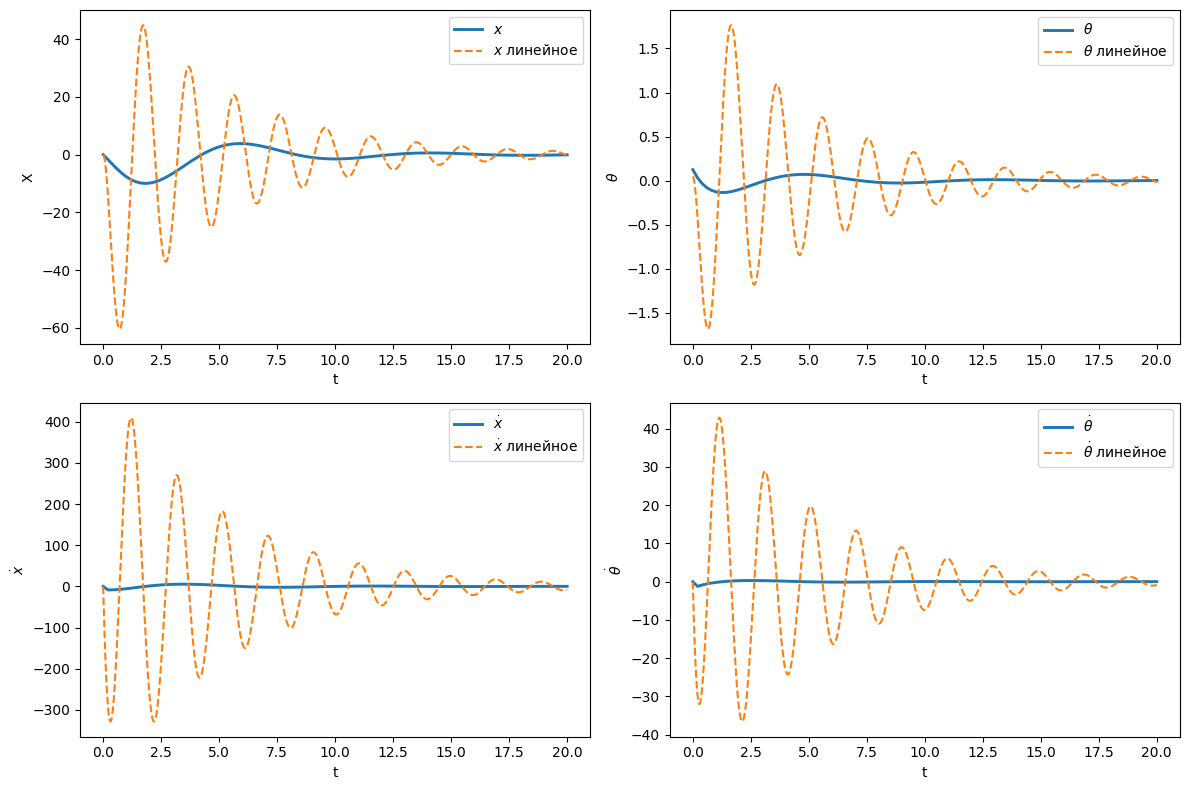

In [95]:
plt.figure(figsize=(12, 8))

# График x1 (позиция)
plt.subplot(2, 2, 1)
#plt.plot(t, x1, label='$x$', color='blue')
plt.plot(sol.t, sol.y[0], label='$x$', linewidth = 2.1)
plt.plot(t, x1, label='$x$ линейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel('X')
plt.grid(False)
plt.legend()

# График x2 (угол)
plt.subplot(2, 2, 2)
#plt.plot(t, x2, label=r'$\theta$', color='blue')
plt.plot(sol.t, sol.y[1]/np.pi, label=r'$\theta$', linewidth = 2.1)
plt.plot(t, x2/np.pi, label=r'$\theta$ линейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel(r'$\theta$')
plt.grid(False)
plt.legend()

# График x3 (скорость позиции)
plt.subplot(2, 2, 3)
#plt.plot(t, x3, label=r'$\dot{x}$', color='blue')
plt.plot(sol.t, sol.y[2], label=r'$\dot{x}$', linewidth = 2.1)
plt.plot(t, x3, label=r'$\dot{x}$ линейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel(r'$\dot{x}$')
plt.grid(False)
plt.legend()

# График x4 (угловая скорость)
plt.subplot(2, 2, 4)
#plt.plot(t, x4, label=r'$\dot{\theta}$', color='blue')
plt.plot(sol.t, sol.y[3], label=r'$\dot{\theta}$', linewidth = 2.1)
plt.plot(t, x4, label=r'$\dot{\theta}$ линейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel(r'$\dot{\theta}$')
plt.grid(False)
plt.legend()

plt.tight_layout()
plt.show()

На графике, линейные системы демонстрируют более быстрые колебания, чем в предыдущем случае. Колебания затухают примерно с той же скоростью, но из-за высокой частоты их гораздо больше в течение определенного временного интервала. 

## 6


In [30]:
P_ = np.array([
    [0.00327109, 0.88683569, 0.00170434, 0.46207018],
    [1,     0,      0,     0],
    [0,     1,      0,     0],
    [0,     0,      1,     0]
]) 
P = np.linalg.inv(P_)

print("P:\n", P) 

P:
 [[ 0.          1.          0.          0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.          0.          1.        ]
 [ 2.16417342 -0.00707921 -1.91926622 -0.00368849]]


In [31]:
C = np.array([
    [1,     0,      0,     0],
    [0,     1,      0,     0],
]) 

Theta1, Theta2, lambda_ = sp.symbols('Theta1 Theta2 lambda')

L_hat = sp.Matrix([
    [Theta1, Theta2, 0, 0],
    [Theta1, Theta2, 0, 0]
])

term1 = P_ @ A.T @ P

term2 = P_ @ C.T @ L_hat

result = term1 - term2

sp.pprint(result, wrap_line=False)

⎡0.521032494481899 - 0.89010678⋅Θ₁  -0.89010678⋅Θ₂ - 4.18237479361207e-9  -3.17562757049169e-8  3.32870047237373e-8⎤
⎢                                                                                                                  ⎥
⎢             -1.0⋅Θ₁                             -1.0⋅Θ₂                          0                     0         ⎥
⎢                                                                                                                  ⎥
⎢      2.34092145916016 - Θ₁             -Θ₂ - 0.00765736477584422         -2.07601269747011     0.056995273920295 ⎥
⎢                                                                                                                  ⎥
⎣        -1.77793338665568                    1.00581578012176              1.57673478172883     -7.48636979701179 ⎦


In [32]:
A_hat = sp.Matrix([
    [0.521032494481899 - 0.89010678*Theta1,     -0.89010678*Theta2 - 4.18237479361207e-9],
    [-1.0*Theta1,     -1.0*Theta2],
])

char_poly = (A_hat - lambda_ * sp.eye(2)).det()

char_poly_simplified = sp.simplify(char_poly)

print("Характеристический полином:")
sp.pprint(char_poly_simplified, wrap_line=False)

Характеристический полином:
                                                                              2                      
0.89010678⋅Θ₁⋅λ - 4.18237479361207e-9⋅Θ₁ + 1.0⋅Θ₂⋅λ - 0.521032494481899⋅Θ₂ + λ  - 0.521032494481899⋅λ


### 6 a

Предполагается, что система будет стремиться к состоянию равновесия асимптотически

#### Двигаем 2 с.ч. в -1

In [33]:
eq1 = char_poly.subs(lambda_, -1)

# Находим производную полинома и подставляем λ = -1
char_poly_derivative = sp.diff(char_poly, lambda_)
eq2 = char_poly_derivative.subs(lambda_, -1)

# 3. Решаем систему уравнений
solutions = sp.solve([eq1, eq2], [Theta1, Theta2], dict=True)

print("\nНайденные решения:")
for sol in solutions:
    print(f"Θ1 = {sol[Theta1].evalf()}, Θ2 = {sol[Theta2].evalf()}")


Найденные решения:
Θ1 = 4.98850107343890, Θ2 = -1.91926613302334


In [34]:
L_hat = np.array([
    [4.98850107343890, -1.91926613302334, 0, 0],
    [4.98850107343890, -1.91926613302334, 0, 0]
])

L = (L_hat @ P_).T
print("L:\n", L)

L:
 [[-1.9029483  -1.9029483 ]
 [ 4.42398079  4.42398079]
 [ 0.0085021   0.0085021 ]
 [ 2.30503759  2.30503759]]


In [35]:
Ac = A - L @ C
Ac

array([[ 1.9029483 ,  1.9029483 ,  1.        ,  0.        ],
       [-4.42398079, -4.42398079,  0.        ,  1.        ],
       [-0.0085021 ,  0.0524829 , -7.4894    , -0.0875    ],
       [-2.30503759, -1.22336759, -0.82153   , -1.55195   ]])

In [40]:
g = 9.81
Kt = 1.726
Ks = 4.487
Bcq = 5.4
m =  0.56
l =  0.1778
Bp = 1.4
I = 0.89
M = 1.206

A1 = m + M
C1 = m * l
D1 = I + m * l**2
K1 = Kt*Ks + Bcq

def systemLinal(x, Y):
    x, fi, y1, y2 = Y
    tu = 0
    return [Ac[0][0] * x + Ac[0][1] * fi + y1, Ac[1][0] * x + Ac[1][1] * fi + y2, Ac[2][0] * x + Ac[2][1]*fi + Ac[2][2] * y1 + Ac[2][3] * y2, Ac[3][0] * x + Ac[3][1] *  fi + Ac[3][2] * y1 + Ac[3][3] * y2]

def system(x, Y):
    y1, y2, y3, y4 = Y

    #u = u1 * y1 + u2 * y2 + u3 * y3 + u4 * y4
    f1 = -K1*y3 - C1 * y4**2 * np.sin(y2)
    f2 = -Bp*y4 + C1 * g * np.sin(y2)

    dydt = [
        -L[0][0] * y1 + -L[0][1] * y2 + y3,
        -L[1][0] * y1 + -L[1][1] * y2 + y4,
        (f1*D1 + f2 * C1 * np.cos(y2))/(A1*D1-(C1*np.cos(y2))**2) + -L[2][0] * y1 + -L[2][1] * y2,
        (f1 * C1 * np.cos(y2) + f2 * A1)/(A1*D1 - (C1*np.cos(y2))**2) + -L[3][0] * y1 + -L[3][1] * y2,
    ]

    return dydt


# Начальные условия
x0 = 0.0
xT = 20.0
y0 = [0.1, 0.0, 0.0, 0.0] 
x_span = (x0, xT)  # интервал по x

# Решаем систему
sol = solve_ivp(system, x_span, y0, t_eval=np.linspace(x0, xT, 100))
solLineal = solve_ivp(systemLinal, x_span, y0, t_eval=np.linspace(x0, xT, 100))


u_nonlin = L[0][0]*sol.y[0] + L[1][0]*sol.y[1] + L[2][0]*sol.y[2] + L[3][0]*sol.y[3]
u_lin = L[0][0]*solLineal.y[0] + L[1][0]*solLineal.y[1] + L[2][0]*solLineal.y[2] + L[3][0]*solLineal.y[3]


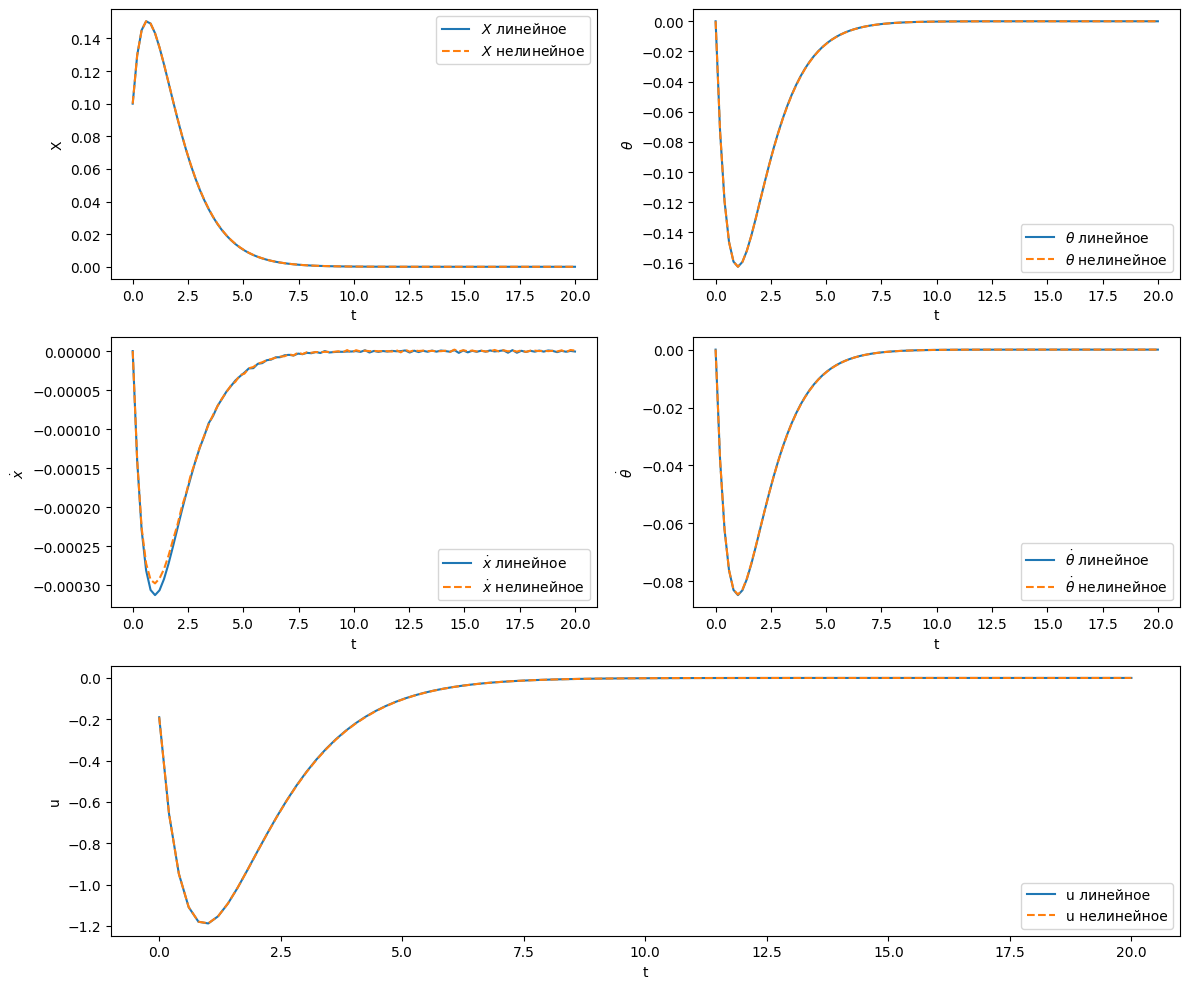

In [41]:
plt.figure(figsize=(12, 10))  # Увеличиваем высоту фигуры, чтобы вместить 5 графиков

# График x1 (позиция)
plt.subplot(3, 2, 1) # 3 строки, 2 столбца, позиция 1
plt.plot(solLineal.t, solLineal.y[0], label='$X$ линейное')
plt.plot(sol.t, sol.y[0], label='$X$ нелинейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel('X')
plt.grid(False)
plt.legend()

# График x2 (угол)
plt.subplot(3, 2, 2) # 3 строки, 2 столбца, позиция 2
plt.plot(solLineal.t, solLineal.y[1], label=r'$\theta$ линейное')
plt.plot(sol.t, sol.y[1], label=r'$\theta$ нелинейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel(r'$\theta$')
plt.grid(False)
plt.legend()

# График x3 (скорость позиции)
plt.subplot(3, 2, 3) # 3 строки, 2 столбца, позиция 3
plt.plot(solLineal.t, solLineal.y[2], label=r'$\dot{x}$ линейное')
plt.plot(sol.t, sol.y[2], label=r'$\dot{x}$ нелинейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel(r'$\dot{x}$')
plt.grid(False)
plt.legend()

# График x4 (угловая скорость)
plt.subplot(3, 2, 4) # 3 строки, 2 столбца, позиция 4
plt.plot(solLineal.t, solLineal.y[3], label=r'$\dot{\theta}$ линейное')
plt.plot(sol.t, sol.y[3], label=r'$\dot{\theta}$ нелинейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel(r'$\dot{\theta}$')
plt.grid(False)
plt.legend()

# График управления (занимает ширину двух графиков)
plt.subplot(3, 1, 3) # 3 строки, 1 столбец, позиция 3 (занимает всю третью строку)
plt.plot(solLineal.t, u_lin, label='u линейное')
plt.plot(sol.t, u_nonlin, label='u нелинейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel('u')
plt.legend()
plt.grid(False)

plt.tight_layout()
plt.show()

По графикам видно, что система стабилизируется в вертикальном положении.

#### Двигаем 2 с.ч. в -1/2

Мы ожидаем, что переходные процессы будут происходить медленнее, чем в предыдущем случае. Следовательно, время, необходимое для достижения устойчивого состояния, увеличится.

In [44]:
eq1 = char_poly.subs(lambda_, -1/2)

# Находим производную полинома и подставляем λ = -1
char_poly_derivative = sp.diff(char_poly, lambda_)
eq2 = char_poly_derivative.subs(lambda_, -1/2)

# 3. Решаем систему уравнений
solutions = sp.solve([eq1, eq2], [Theta1, Theta2], dict=True)

print("\nНайденные решения:")
for sol in solutions:
    print(f"Θ1 = {sol[Theta1].evalf()}, Θ2 = {sol[Theta2].evalf()}")


Найденные решения:
Θ1 = 2.24787528949150, Θ2 = -0.479816541288949


In [45]:
L_hat = np.array([
    [2.24787528949150, -0.479816541288949, 0, 0],
    [2.24787528949150, -0.479816541288949, 0, 0]
])

L = (L_hat @ P_).T
print("L:\n", L)

L:
 [[-0.47246354 -0.47246354]
 [ 1.99349603  1.99349603]
 [ 0.00383114  0.00383114]
 [ 1.03867614  1.03867614]]


In [46]:
Ac = A - L @ C
print(Ac)

[[ 4.72463539e-01  4.72463539e-01  1.00000000e+00  0.00000000e+00]
 [-1.99349603e+00 -1.99349603e+00  0.00000000e+00  1.00000000e+00]
 [-3.83114377e-03  5.71538562e-02 -7.48940000e+00 -8.75000000e-02]
 [-1.03867614e+00  4.29938604e-02 -8.21530000e-01 -1.55195000e+00]]


In [28]:
g = 9.81
Kt = 1.726
Ks = 4.487
Bcq = 5.4
m =  0.56
l =  0.1778
Bp = 1.4
I = 0.89
M = 1.206

A1 = m + M
C1 = m * l
D1 = I + m * l**2
K1 = Kt*Ks + Bcq

def systemLinal(x, Y):
    x, fi, y1, y2 = Y
    tu = 0
    return [Ac[0][0] * x + Ac[0][1] * fi + y1, Ac[1][0] * x + Ac[1][1] * fi + y2, Ac[2][0] * x + Ac[2][1]*fi + Ac[2][2] * y1 + Ac[2][3] * y2, Ac[3][0] * x + Ac[3][1] *  fi + Ac[3][2] * y1 + Ac[3][3] * y2]

def system(x, Y):
    y1, y2, y3, y4 = Y

    #u = u1 * y1 + u2 * y2 + u3 * y3 + u4 * y4
    f1 = -K1*y3 - C1 * y4**2 * np.sin(y2)
    f2 = -Bp*y4 + C1 * g * np.sin(y2)

    dydt = [
        -L[0][0] * y1 + -L[0][1] * y2 + y3,
        -L[1][0] * y1 + -L[1][1] * y2 + y4,
        (f1*D1 + f2 * C1 * np.cos(y2))/(A1*D1-(C1*np.cos(y2))**2) + -L[2][0] * y1 + -L[2][1] * y2,
        (f1 * C1 * np.cos(y2) + f2 * A1)/(A1*D1 - (C1*np.cos(y2))**2) + -L[3][0] * y1 + -L[3][1] * y2,
    ]

    return dydt


# Начальные условия
x0 = 0.0
xT = 20.0
y0 = [0.2, 0.15, 0.2, 0.3] 
x_span = (x0, xT)  # интервал по x

# Решаем систему
sol = solve_ivp(system, x_span, y0, t_eval=np.linspace(x0, xT, 100))
solLineal = solve_ivp(systemLinal, x_span, y0, t_eval=np.linspace(x0, xT, 100))

u_nonlin = L[0][0]*sol.y[0] + L[1][0]*sol.y[1] + L[2][0]*sol.y[2] + L[3][0]*sol.y[3]
u_lin = L[0][0]*solLineal.y[0] + L[1][0]*solLineal.y[1] + L[2][0]*solLineal.y[2] + L[3][0]*solLineal.y[3]

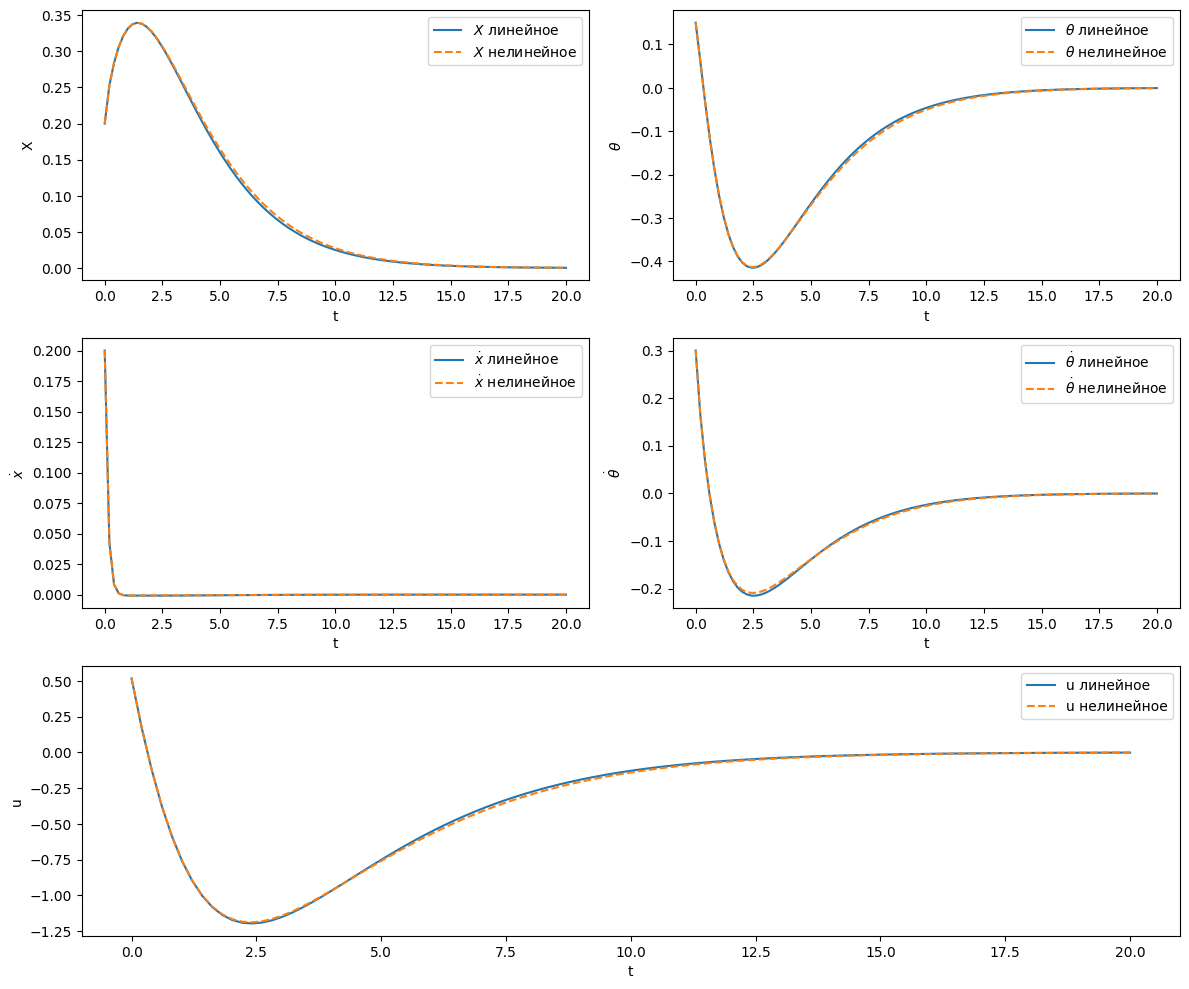

In [29]:
plt.figure(figsize=(12, 10))  # Увеличиваем высоту фигуры, чтобы вместить 5 графиков

# График x1 (позиция)
plt.subplot(3, 2, 1) # 3 строки, 2 столбца, позиция 1
plt.plot(solLineal.t, solLineal.y[0], label='$X$ линейное')
plt.plot(sol.t, sol.y[0], label='$X$ нелинейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel('X')
plt.grid(False)
plt.legend()

# График x2 (угол)
plt.subplot(3, 2, 2) # 3 строки, 2 столбца, позиция 2
plt.plot(solLineal.t, solLineal.y[1], label=r'$\theta$ линейное')
plt.plot(sol.t, sol.y[1], label=r'$\theta$ нелинейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel(r'$\theta$')
plt.grid(False)
plt.legend()

# График x3 (скорость позиции)
plt.subplot(3, 2, 3) # 3 строки, 2 столбца, позиция 3
plt.plot(solLineal.t, solLineal.y[2], label=r'$\dot{x}$ линейное')
plt.plot(sol.t, sol.y[2], label=r'$\dot{x}$ нелинейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel(r'$\dot{x}$')
plt.grid(False)
plt.legend()

# График x4 (угловая скорость)
plt.subplot(3, 2, 4) # 3 строки, 2 столбца, позиция 4
plt.plot(solLineal.t, solLineal.y[3], label=r'$\dot{\theta}$ линейное')
plt.plot(sol.t, sol.y[3], label=r'$\dot{\theta}$ нелинейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel(r'$\dot{\theta}$')
plt.grid(False)
plt.legend()

# График управления (занимает ширину двух графиков)
plt.subplot(3, 1, 3) # 3 строки, 1 столбец, позиция 3 (занимает всю третью строку)
plt.plot(solLineal.t, u_lin, label='u линейное')
plt.plot(sol.t, u_nonlin, label='u нелинейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel('u')
plt.legend()
plt.grid(False)

plt.tight_layout()
plt.show()

Уменьшение величины собственных значений с -1 до -1/2 действительно привело к замедлению затухания, как и ожидалось.

#### Двигаем 2 с.ч. в -10

In [30]:
eq1 = char_poly.subs(lambda_, -10)

# Находим производную полинома и подставляем λ = -1
char_poly_derivative = sp.diff(char_poly, lambda_)
eq2 = char_poly_derivative.subs(lambda_, -10)

# 3. Решаем систему уравнений
solutions = sp.solve([eq1, eq2], [Theta1, Theta2], dict=True)

print("\nНайденные решения:")
for sol in solutions:
    print(f"Θ1 = {sol[Theta1].evalf()}, Θ2 = {sol[Theta2].evalf()}")


Найденные решения:
Θ1 = 238.676581823567, Θ2 = -191.926611213900


In [31]:
L_hat = np.array([
    [238.676581823567, -191.926611213900, 0, 0],
    [238.676581823567, -191.926611213900, 0, 0]
])

L = (L_hat @ P_).T
print("L:\n", L)

L:
 [[-191.14587863 -191.14587863]
 [ 211.66691113  211.66691113]
 [   0.40678605    0.40678605]
 [ 110.28533113  110.28533113]]


In [32]:
Ac = A - L @ C
print(Ac)

[[ 1.91145879e+02  1.91145879e+02  1.00000000e+00  0.00000000e+00]
 [-2.11666911e+02 -2.11666911e+02  0.00000000e+00  1.00000000e+00]
 [-4.06786045e-01 -3.45801045e-01 -7.48940000e+00 -8.75000000e-02]
 [-1.10285331e+02 -1.09203661e+02 -8.21530000e-01 -1.55195000e+00]]


In [35]:
g = 9.81
Kt = 1.726
Ks = 4.487
Bcq = 5.4
m =  0.56
l =  0.1778
Bp = 1.4
I = 0.89
M = 1.206

A1 = m + M
C1 = m * l
D1 = I + m * l**2
K1 = Kt*Ks + Bcq

def systemLinal(x, Y):
    x, fi, y1, y2 = Y
    tu = 0
    return [Ac[0][0] * x + Ac[0][1] * fi + y1, Ac[1][0] * x + Ac[1][1] * fi + y2, Ac[2][0] * x + Ac[2][1]*fi + Ac[2][2] * y1 + Ac[2][3] * y2, Ac[3][0] * x + Ac[3][1] *  fi + Ac[3][2] * y1 + Ac[3][3] * y2]

def system(x, Y):
    y1, y2, y3, y4 = Y

    #u = u1 * y1 + u2 * y2 + u3 * y3 + u4 * y4
    f1 = -K1*y3 - C1 * y4**2 * np.sin(y2)
    f2 = -Bp*y4 + C1 * g * np.sin(y2)

    dydt = [
        -L[0][0] * y1 + -L[0][1] * y2 + y3,
        -L[1][0] * y1 + -L[1][1] * y2 + y4,
        (f1*D1 + f2 * C1 * np.cos(y2))/(A1*D1-(C1*np.cos(y2))**2) + -L[2][0] * y1 + -L[2][1] * y2,
        (f1 * C1 * np.cos(y2) + f2 * A1)/(A1*D1 - (C1*np.cos(y2))**2) + -L[3][0] * y1 + -L[3][1] * y2,
    ]

    return dydt


# Начальные условия
x0 = 0.0
xT = 10.0
y0 = [0.2, 0.15, 0.2, 0.3] 
x_span = (x0, xT)  # интервал по x

# Решаем систему
sol = solve_ivp(system, x_span, y0, t_eval=np.linspace(x0, xT, 100))
solLineal = solve_ivp(systemLinal, x_span, y0, t_eval=np.linspace(x0, xT, 100))

u_nonlin = L[0][0]*sol.y[0] + L[1][0]*sol.y[1] + L[2][0]*sol.y[2] + L[3][0]*sol.y[3]
u_lin = L[0][0]*solLineal.y[0] + L[1][0]*solLineal.y[1] + L[2][0]*solLineal.y[2] + L[3][0]*solLineal.y[3]

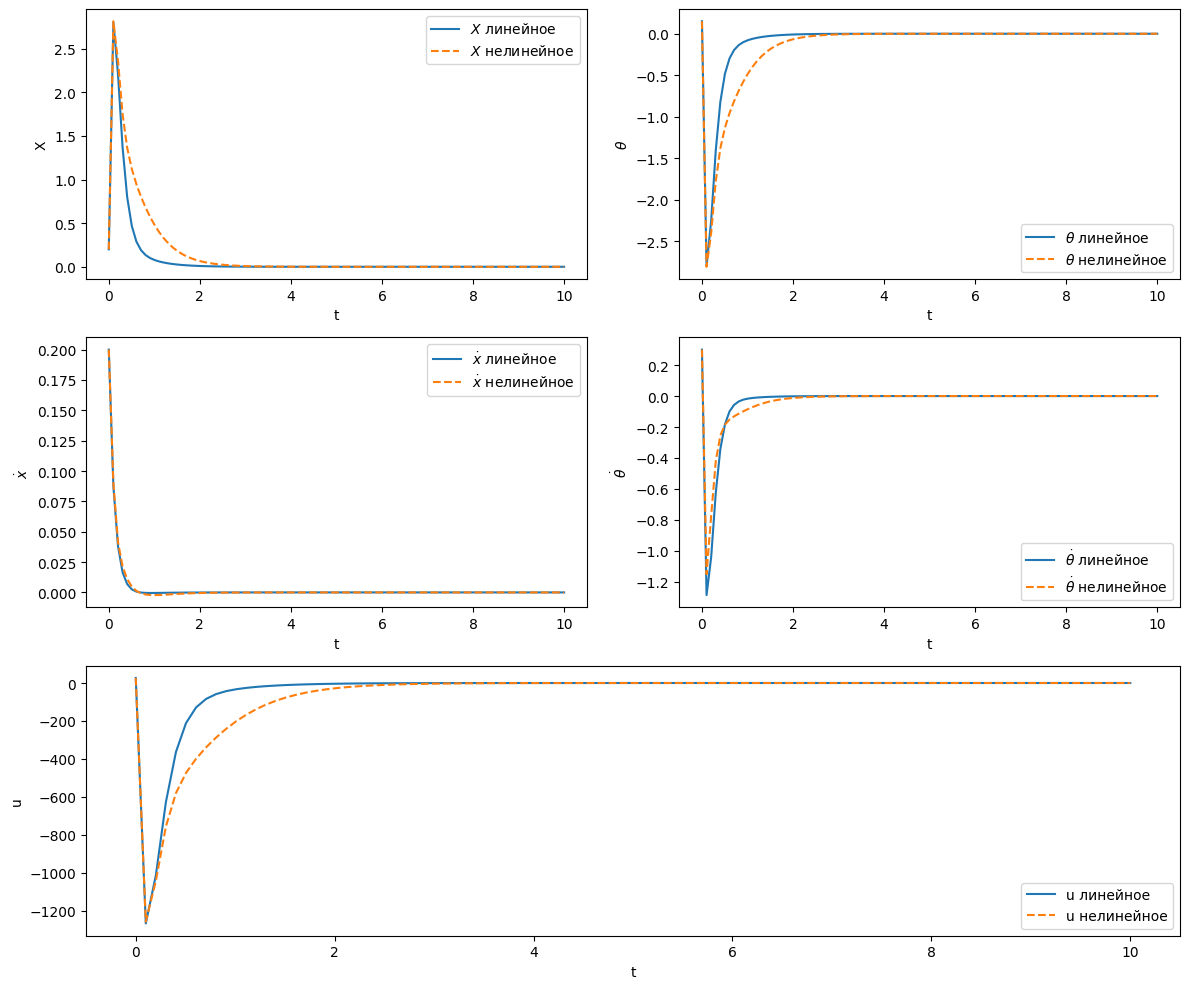

In [36]:
plt.figure(figsize=(12, 10))  # Увеличиваем высоту фигуры, чтобы вместить 5 графиков

# График x1 (позиция)
plt.subplot(3, 2, 1) # 3 строки, 2 столбца, позиция 1
plt.plot(solLineal.t, solLineal.y[0], label='$X$ линейное')
plt.plot(sol.t, sol.y[0], label='$X$ нелинейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel('X')
plt.grid(False)
plt.legend()

# График x2 (угол)
plt.subplot(3, 2, 2) # 3 строки, 2 столбца, позиция 2
plt.plot(solLineal.t, solLineal.y[1], label=r'$\theta$ линейное')
plt.plot(sol.t, sol.y[1], label=r'$\theta$ нелинейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel(r'$\theta$')
plt.grid(False)
plt.legend()

# График x3 (скорость позиции)
plt.subplot(3, 2, 3) # 3 строки, 2 столбца, позиция 3
plt.plot(solLineal.t, solLineal.y[2], label=r'$\dot{x}$ линейное')
plt.plot(sol.t, sol.y[2], label=r'$\dot{x}$ нелинейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel(r'$\dot{x}$')
plt.grid(False)
plt.legend()

# График x4 (угловая скорость)
plt.subplot(3, 2, 4) # 3 строки, 2 столбца, позиция 4
plt.plot(solLineal.t, solLineal.y[3], label=r'$\dot{\theta}$ линейное')
plt.plot(sol.t, sol.y[3], label=r'$\dot{\theta}$ нелинейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel(r'$\dot{\theta}$')
plt.grid(False)
plt.legend()

# График управления (занимает ширину двух графиков)
plt.subplot(3, 1, 3) # 3 строки, 1 столбец, позиция 3 (занимает всю третью строку)
plt.plot(solLineal.t, u_lin, label='u линейное')
plt.plot(sol.t, u_nonlin, label='u нелинейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel('u')
plt.legend()
plt.grid(False)

plt.tight_layout()
plt.show()

### 6 б

#### Двигаем 2 с.ч. в -2 +- 3i

In [37]:
lambda1 = -2 + 3j  
lambda2 = -2 - 3j

eq1 = char_poly.subs('lambda', lambda1)
eq2 = char_poly.subs('lambda', lambda2)

# Решаем систему уравнений для Θ₁ и Θ₂
solutions = sp.solve([sp.re(eq1), sp.re(eq2), sp.im(eq1), sp.im(eq2)], [Theta1, Theta2], dict=True)

print("\nНайденные решения:")
for sol in solutions:
    print(f"Θ1 = {sol[Theta1].evalf()}, Θ2 = {sol[Theta2].evalf()}")


Найденные решения:
Θ1 = 33.1100634566580, Θ2 = -24.9504594745197


In [38]:
L_hat = np.array([
    [33.1100634566580, -24.9504594745197, 0, 0],
    [33.1100634566580, -24.9504594745197, 0, 0]
])

L = (L_hat @ P_).T
print("L:\n", L)

L:
 [[-24.84215348 -24.84215348]
 [ 29.36318597  29.36318597]
 [  0.05643081   0.05643081]
 [ 15.29917298  15.29917298]]


In [39]:
Ac = A - L @ C
print(Ac)

[[ 2.48421535e+01  2.48421535e+01  1.00000000e+00  0.00000000e+00]
 [-2.93631860e+01 -2.93631860e+01  0.00000000e+00  1.00000000e+00]
 [-5.64308056e-02  4.55419445e-03 -7.48940000e+00 -8.75000000e-02]
 [-1.52991730e+01 -1.42175030e+01 -8.21530000e-01 -1.55195000e+00]]


In [42]:
g = 9.81
Kt = 1.726
Ks = 4.487
Bcq = 5.4
m =  0.56
l =  0.1778
Bp = 1.4
I = 0.89
M = 1.206

A1 = m + M
C1 = m * l
D1 = I + m * l**2
K1 = Kt*Ks + Bcq

def systemLinal(x, Y):
    x, fi, y1, y2 = Y
    tu = 0
    return [Ac[0][0] * x + Ac[0][1] * fi + y1, Ac[1][0] * x + Ac[1][1] * fi + y2, Ac[2][0] * x + Ac[2][1]*fi + Ac[2][2] * y1 + Ac[2][3] * y2, Ac[3][0] * x + Ac[3][1] *  fi + Ac[3][2] * y1 + Ac[3][3] * y2]

def system(x, Y):
    y1, y2, y3, y4 = Y

    #u = u1 * y1 + u2 * y2 + u3 * y3 + u4 * y4
    f1 = -K1*y3 - C1 * y4**2 * np.sin(y2)
    f2 = -Bp*y4 + C1 * g * np.sin(y2)

    dydt = [
        -L[0][0] * y1 + -L[0][1] * y2 + y3,
        -L[1][0] * y1 + -L[1][1] * y2 + y4,
        (f1*D1 + f2 * C1 * np.cos(y2))/(A1*D1-(C1*np.cos(y2))**2) + -L[2][0] * y1 + -L[2][1] * y2,
        (f1 * C1 * np.cos(y2) + f2 * A1)/(A1*D1 - (C1*np.cos(y2))**2) + -L[3][0] * y1 + -L[3][1] * y2,
    ]

    return dydt

# Начальные условия
x0 = 0.0
xT = 10.0
y0 = [0.2, 0.15, 0.2, 0.3] 
x_span = (x0, xT)  # интервал по x

# Решаем систему
sol = solve_ivp(system, x_span, y0, t_eval=np.linspace(x0, xT, 100))
solLineal = solve_ivp(systemLinal, x_span, y0, t_eval=np.linspace(x0, xT, 100))

u_nonlin = L[0][0]*sol.y[0] + L[1][0]*sol.y[1] + L[2][0]*sol.y[2] + L[3][0]*sol.y[3]
u_lin = L[0][0]*solLineal.y[0] + L[1][0]*solLineal.y[1] + L[2][0]*solLineal.y[2] + L[3][0]*solLineal.y[3]

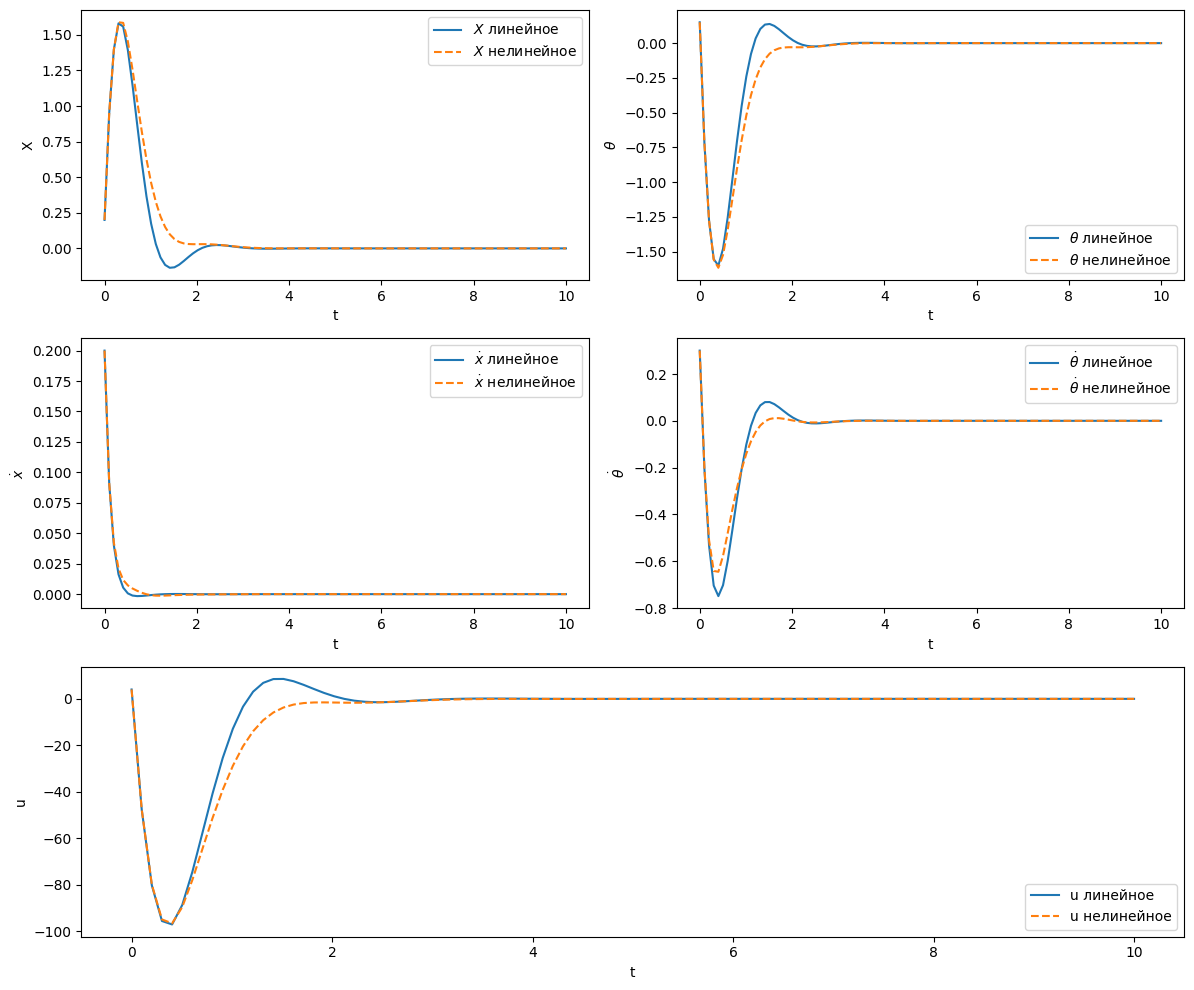

In [43]:
plt.figure(figsize=(12, 10))  # Увеличиваем высоту фигуры, чтобы вместить 5 графиков

# График x1 (позиция)
plt.subplot(3, 2, 1) # 3 строки, 2 столбца, позиция 1
plt.plot(solLineal.t, solLineal.y[0], label='$X$ линейное')
plt.plot(sol.t, sol.y[0], label='$X$ нелинейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel('X')
plt.grid(False)
plt.legend()

# График x2 (угол)
plt.subplot(3, 2, 2) # 3 строки, 2 столбца, позиция 2
plt.plot(solLineal.t, solLineal.y[1], label=r'$\theta$ линейное')
plt.plot(sol.t, sol.y[1], label=r'$\theta$ нелинейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel(r'$\theta$')
plt.grid(False)
plt.legend()

# График x3 (скорость позиции)
plt.subplot(3, 2, 3) # 3 строки, 2 столбца, позиция 3
plt.plot(solLineal.t, solLineal.y[2], label=r'$\dot{x}$ линейное')
plt.plot(sol.t, sol.y[2], label=r'$\dot{x}$ нелинейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel(r'$\dot{x}$')
plt.grid(False)
plt.legend()

# График x4 (угловая скорость)
plt.subplot(3, 2, 4) # 3 строки, 2 столбца, позиция 4
plt.plot(solLineal.t, solLineal.y[3], label=r'$\dot{\theta}$ линейное')
plt.plot(sol.t, sol.y[3], label=r'$\dot{\theta}$ нелинейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel(r'$\dot{\theta}$')
plt.grid(False)
plt.legend()

# График управления (занимает ширину двух графиков)
plt.subplot(3, 1, 3) # 3 строки, 1 столбец, позиция 3 (занимает всю третью строку)
plt.plot(solLineal.t, u_lin, label='u линейное')
plt.plot(sol.t, u_nonlin, label='u нелинейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel('u')
plt.legend()
plt.grid(False)

plt.tight_layout()
plt.show()

#### Двигаем 2 с.ч. в -1/2 +- 2i

In [44]:
lambda1 = -1/2 + 2j  
lambda2 = -1/2 - 2j

eq1 = char_poly.subs('lambda', lambda1)
eq2 = char_poly.subs('lambda', lambda2)

# Решаем систему уравнений для Θ₁ и Θ₂
solutions = sp.solve([sp.re(eq1), sp.re(eq2), sp.im(eq1), sp.im(eq2)], [Theta1, Theta2], dict=True)

print("\nНайденные решения:")
for sol in solutions:
    print(f"Θ1 = {sol[Theta1].evalf()}, Θ2 = {sol[Theta2].evalf()}")


Найденные решения:
Θ1 = 10.8727556000914, Θ2 = -8.15688098244241


In [45]:
L_hat = np.array([
    [10.8727556000914, -8.15688098244241, 0, 0],
    [10.8727556000914, -8.15688098244241, 0, 0]
])

L = (L_hat @ P_).T
print("L:\n", L)

L:
 [[-8.12131522 -8.12131522]
 [ 9.64234771  9.64234771]
 [ 0.01853087  0.01853087]
 [ 5.02397614  5.02397614]]


In [46]:
Ac = A - L @ C
print(Ac)

[[ 8.12131522  8.12131522  1.          0.        ]
 [-9.64234771 -9.64234771  0.          1.        ]
 [-0.01853087  0.04245413 -7.4894     -0.0875    ]
 [-5.02397614 -3.94230614 -0.82153    -1.55195   ]]


In [47]:
g = 9.81
Kt = 1.726
Ks = 4.487
Bcq = 5.4
m =  0.56
l =  0.1778
Bp = 1.4
I = 0.89
M = 1.206

A1 = m + M
C1 = m * l
D1 = I + m * l**2
K1 = Kt*Ks + Bcq

def systemLinal(x, Y):
    x, fi, y1, y2 = Y
    tu = 0
    return [Ac[0][0] * x + Ac[0][1] * fi + y1, Ac[1][0] * x + Ac[1][1] * fi + y2, Ac[2][0] * x + Ac[2][1]*fi + Ac[2][2] * y1 + Ac[2][3] * y2, Ac[3][0] * x + Ac[3][1] *  fi + Ac[3][2] * y1 + Ac[3][3] * y2]

def system(x, Y):
    y1, y2, y3, y4 = Y

    #u = u1 * y1 + u2 * y2 + u3 * y3 + u4 * y4
    f1 = -K1*y3 - C1 * y4**2 * np.sin(y2)
    f2 = -Bp*y4 + C1 * g * np.sin(y2)

    dydt = [
        -L[0][0] * y1 + -L[0][1] * y2 + y3,
        -L[1][0] * y1 + -L[1][1] * y2 + y4,
        (f1*D1 + f2 * C1 * np.cos(y2))/(A1*D1-(C1*np.cos(y2))**2) + -L[2][0] * y1 + -L[2][1] * y2,
        (f1 * C1 * np.cos(y2) + f2 * A1)/(A1*D1 - (C1*np.cos(y2))**2) + -L[3][0] * y1 + -L[3][1] * y2,
    ]

    return dydt

# Начальные условия
x0 = 0.0
xT = 10.0
y0 = [0.2, 0.15, 0.2, 0.3] 
x_span = (x0, xT)  # интервал по x

# Решаем систему
sol = solve_ivp(system, x_span, y0, t_eval=np.linspace(x0, xT, 100))
solLineal = solve_ivp(systemLinal, x_span, y0, t_eval=np.linspace(x0, xT, 100))

u_nonlin = L[0][0]*sol.y[0] + L[1][0]*sol.y[1] + L[2][0]*sol.y[2] + L[3][0]*sol.y[3]
u_lin = L[0][0]*solLineal.y[0] + L[1][0]*solLineal.y[1] + L[2][0]*solLineal.y[2] + L[3][0]*solLineal.y[3]

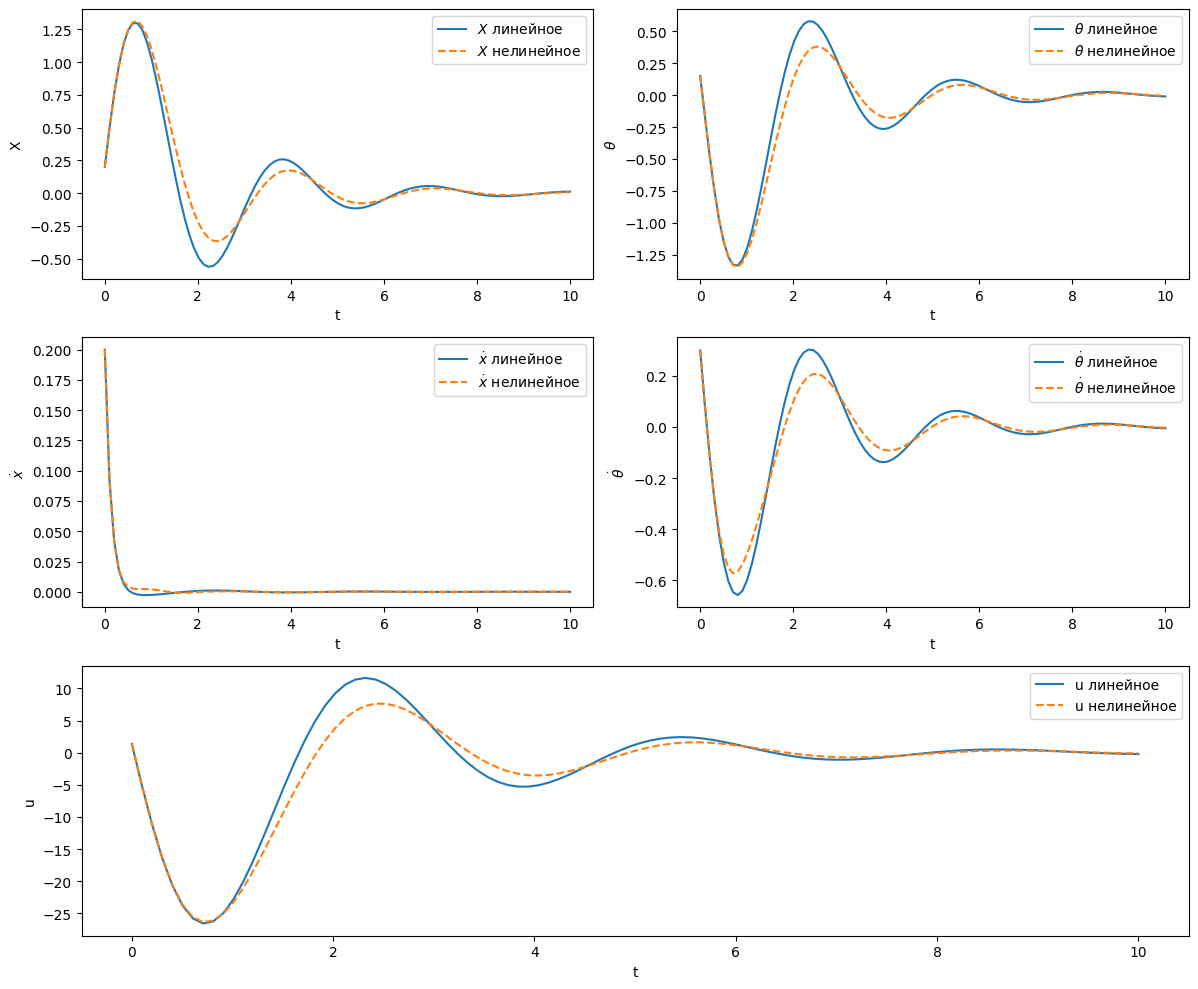

In [48]:
plt.figure(figsize=(12, 10))  # Увеличиваем высоту фигуры, чтобы вместить 5 графиков

# График x1 (позиция)
plt.subplot(3, 2, 1) # 3 строки, 2 столбца, позиция 1
plt.plot(solLineal.t, solLineal.y[0], label='$X$ линейное')
plt.plot(sol.t, sol.y[0], label='$X$ нелинейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel('X')
plt.grid(False)
plt.legend()

# График x2 (угол)
plt.subplot(3, 2, 2) # 3 строки, 2 столбца, позиция 2
plt.plot(solLineal.t, solLineal.y[1], label=r'$\theta$ линейное')
plt.plot(sol.t, sol.y[1], label=r'$\theta$ нелинейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel(r'$\theta$')
plt.grid(False)
plt.legend()

# График x3 (скорость позиции)
plt.subplot(3, 2, 3) # 3 строки, 2 столбца, позиция 3
plt.plot(solLineal.t, solLineal.y[2], label=r'$\dot{x}$ линейное')
plt.plot(sol.t, sol.y[2], label=r'$\dot{x}$ нелинейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel(r'$\dot{x}$')
plt.grid(False)
plt.legend()

# График x4 (угловая скорость)
plt.subplot(3, 2, 4) # 3 строки, 2 столбца, позиция 4
plt.plot(solLineal.t, solLineal.y[3], label=r'$\dot{\theta}$ линейное')
plt.plot(sol.t, sol.y[3], label=r'$\dot{\theta}$ нелинейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel(r'$\dot{\theta}$')
plt.grid(False)
plt.legend()

# График управления (занимает ширину двух графиков)
plt.subplot(3, 1, 3) # 3 строки, 1 столбец, позиция 3 (занимает всю третью строку)
plt.plot(solLineal.t, u_lin, label='u линейное')
plt.plot(sol.t, u_nonlin, label='u нелинейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel('u')
plt.legend()
plt.grid(False)

plt.tight_layout()
plt.show()

#### Двигаем 2 с.ч. в -1/2 +- 8i

In [49]:
lambda1 = -1/2 + 8j  
lambda2 = -1/2 - 8j

eq1 = char_poly.subs('lambda', lambda1)
eq2 = char_poly.subs('lambda', lambda2)

# Решаем систему уравнений для Θ₁ и Θ₂
solutions = sp.solve([sp.re(eq1), sp.re(eq2), sp.im(eq1), sp.im(eq2)], [Theta1, Theta2], dict=True)

print("\nНайденные решения:")
for sol in solutions:
    print(f"Θ1 = {sol[Theta1].evalf()}, Θ2 = {sol[Theta2].evalf()}")


Найденные решения:
Θ1 = 140.245960259090, Θ2 = -123.312847599744


In [50]:
L_hat = np.array([
    [140.245960259090, -123.312847599744, 0, 0],
    [140.245960259090, -123.312847599744, 0, 0]
])

L = (L_hat @ P_).T
print("L:\n", L)

L:
 [[-122.85409044 -122.85409044]
 [ 124.37512294  124.37512294]
 [   0.2390268     0.2390268 ]
 [  64.8034761    64.8034761 ]]


In [51]:
Ac = A - L @ C
print(Ac)

[[ 1.22854090e+02  1.22854090e+02  1.00000000e+00  0.00000000e+00]
 [-1.24375123e+02 -1.24375123e+02  0.00000000e+00  1.00000000e+00]
 [-2.39026800e-01 -1.78041800e-01 -7.48940000e+00 -8.75000000e-02]
 [-6.48034761e+01 -6.37218061e+01 -8.21530000e-01 -1.55195000e+00]]


In [54]:
g = 9.81
Kt = 1.726
Ks = 4.487
Bcq = 5.4
m =  0.56
l =  0.1778
Bp = 1.4
I = 0.89
M = 1.206

A1 = m + M
C1 = m * l
D1 = I + m * l**2
K1 = Kt*Ks + Bcq

def systemLinal(x, Y):
    x, fi, y1, y2 = Y
    tu = 0
    return [Ac[0][0] * x + Ac[0][1] * fi + y1, Ac[1][0] * x + Ac[1][1] * fi + y2, Ac[2][0] * x + Ac[2][1]*fi + Ac[2][2] * y1 + Ac[2][3] * y2, Ac[3][0] * x + Ac[3][1] *  fi + Ac[3][2] * y1 + Ac[3][3] * y2]

def system(x, Y):
    y1, y2, y3, y4 = Y

    #u = u1 * y1 + u2 * y2 + u3 * y3 + u4 * y4
    f1 = -K1*y3 - C1 * y4**2 * np.sin(y2)
    f2 = -Bp*y4 + C1 * g * np.sin(y2)

    dydt = [
        -L[0][0] * y1 + -L[0][1] * y2 + y3,
        -L[1][0] * y1 + -L[1][1] * y2 + y4,
        (f1*D1 + f2 * C1 * np.cos(y2))/(A1*D1-(C1*np.cos(y2))**2) + -L[2][0] * y1 + -L[2][1] * y2,
        (f1 * C1 * np.cos(y2) + f2 * A1)/(A1*D1 - (C1*np.cos(y2))**2) + -L[3][0] * y1 + -L[3][1] * y2,
    ]

    return dydt

# Начальные условия
x0 = 0.0
xT = 8.0
y0 = [0.2, 0.15, 0.2, 0.3] 
x_span = (x0, xT)  # интервал по x

# Решаем систему
sol = solve_ivp(system, x_span, y0, t_eval=np.linspace(x0, xT, 100))
solLineal = solve_ivp(systemLinal, x_span, y0, t_eval=np.linspace(x0, xT, 100))

u_nonlin = L[0][0]*sol.y[0] + L[1][0]*sol.y[1] + L[2][0]*sol.y[2] + L[3][0]*sol.y[3]
u_lin = L[0][0]*solLineal.y[0] + L[1][0]*solLineal.y[1] + L[2][0]*solLineal.y[2] + L[3][0]*solLineal.y[3]

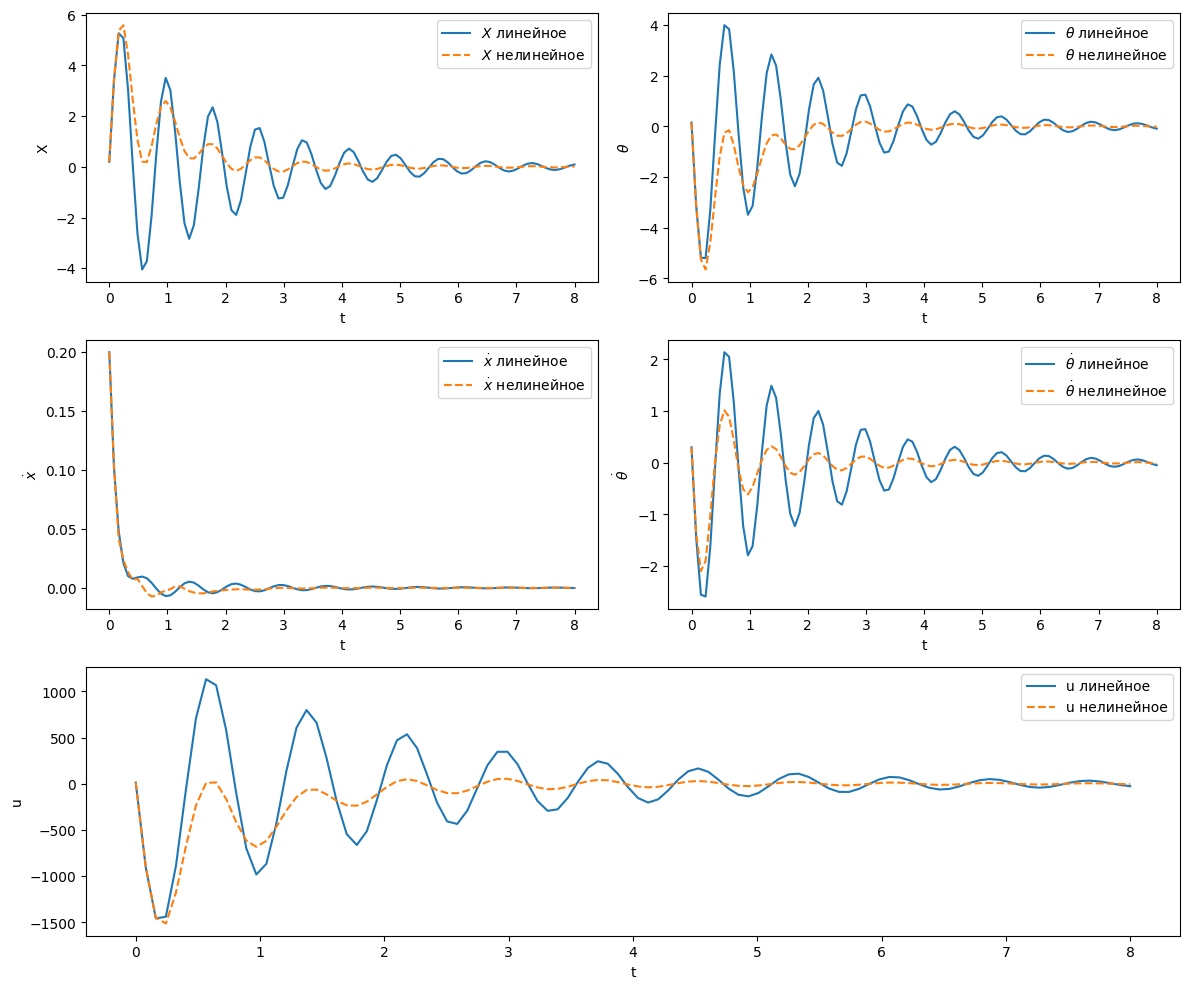

In [55]:
plt.figure(figsize=(12, 10))  # Увеличиваем высоту фигуры, чтобы вместить 5 графиков

# График x1 (позиция)
plt.subplot(3, 2, 1) # 3 строки, 2 столбца, позиция 1
plt.plot(solLineal.t, solLineal.y[0], label='$X$ линейное')
plt.plot(sol.t, sol.y[0], label='$X$ нелинейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel('X')
plt.grid(False)
plt.legend()

# График x2 (угол)
plt.subplot(3, 2, 2) # 3 строки, 2 столбца, позиция 2
plt.plot(solLineal.t, solLineal.y[1], label=r'$\theta$ линейное')
plt.plot(sol.t, sol.y[1], label=r'$\theta$ нелинейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel(r'$\theta$')
plt.grid(False)
plt.legend()

# График x3 (скорость позиции)
plt.subplot(3, 2, 3) # 3 строки, 2 столбца, позиция 3
plt.plot(solLineal.t, solLineal.y[2], label=r'$\dot{x}$ линейное')
plt.plot(sol.t, sol.y[2], label=r'$\dot{x}$ нелинейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel(r'$\dot{x}$')
plt.grid(False)
plt.legend()

# График x4 (угловая скорость)
plt.subplot(3, 2, 4) # 3 строки, 2 столбца, позиция 4
plt.plot(solLineal.t, solLineal.y[3], label=r'$\dot{\theta}$ линейное')
plt.plot(sol.t, sol.y[3], label=r'$\dot{\theta}$ нелинейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel(r'$\dot{\theta}$')
plt.grid(False)
plt.legend()

# График управления (занимает ширину двух графиков)
plt.subplot(3, 1, 3) # 3 строки, 1 столбец, позиция 3 (занимает всю третью строку)
plt.plot(solLineal.t, u_lin, label='u линейное')
plt.plot(sol.t, u_nonlin, label='u нелинейное', linestyle = '--')
plt.xlabel('t')
plt.ylabel('u')
plt.legend()
plt.grid(False)

plt.tight_layout()
plt.show()

In [42]:
A_init_mat = np.array([
    [0, 0,         1,             0],
    [0, 0,         0,             1],
    [0, 0.060985, -7.4894,  -0.0875],
    [0, 1.08167, -0.82153, -1.55195]
])
B_mat = np.array([
    0,
    0,
    0.98343,
    0.10787
])

CONTROL_COEFFICIENTS= np.array([
    190.01243504,
    -8675.207539,
    456.58683891,
    -4204.52607265
])

L_mat = np.array([
    [-24.84215348, -24.84215348],
    [29.36318597, 29.36318597],
    [0.05643081, 0.05643081],
    [15.29917298, 15.29917298]
])

g = 9.81
Kt = 1.726
Ks = 4.487
Bcq = 5.4
m =  0.56
l =  0.1778
Bp = 1.4
I = 0.89
M = 1.206

A1 = m + M
C1 = m * l
D1 = I + m * l**2
K1 = Kt*Ks + Bcq

RTOL_MAX = 1e-13
MAX_TIME_PLOT = 15.0
INIT_POINT = [0.0, np.pi/8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

T_SPAN = [0, 10]
T_EVAL = np.linspace(*T_SPAN, 1000)

def rhs_linear_controlled(t, X):
    x1, x2, x3, x4, y1, y2, y3, y4 = X

    V = CONTROL_COEFFICIENTS[0] * y1 + CONTROL_COEFFICIENTS[1] * y2 + CONTROL_COEFFICIENTS[2] * y3 + CONTROL_COEFFICIENTS[3] * y4

    _x1 = A_init_mat[0, 0] * x1 + A_init_mat[0, 1] * x2 + A_init_mat[0, 2] * x3 + A_init_mat[0, 3] * x4 + V * B_mat[0]
    _x2 = A_init_mat[1, 0] * x1 + A_init_mat[1, 1] * x2 + A_init_mat[1, 2] * x3 + A_init_mat[1, 3] * x4 + V * B_mat[1]
    _x3 = A_init_mat[2, 0] * x1 + A_init_mat[2, 1] * x2 + A_init_mat[2, 2] * x3 + A_init_mat[2, 3] * x4 + V * B_mat[2]
    _x4 = A_init_mat[3, 0] * x1 + A_init_mat[3, 1] * x2 + A_init_mat[3, 2] * x3 + A_init_mat[3, 3] * x4 + V * B_mat[3]

    _y1 = A_init_mat[0, 0] * y1 + A_init_mat[0, 1] * y2 + A_init_mat[0, 2] * y3 + A_init_mat[0, 3] * y4 + V * B_mat[0] + L_mat[0, 0] * (x1 - y1) + L_mat[0, 1] * (x2 - y2)
    _y2 = A_init_mat[1, 0] * y1 + A_init_mat[1, 1] * y2 + A_init_mat[1, 2] * y3 + A_init_mat[1, 3] * y4 + V * B_mat[1] + L_mat[1, 0] * (x1 - y1) + L_mat[1, 1] * (x2 - y2)
    _y3 = A_init_mat[2, 0] * y1 + A_init_mat[2, 1] * y2 + A_init_mat[2, 2] * y3 + A_init_mat[2, 3] * y4 + V * B_mat[2] + L_mat[2, 0] * (x1 - y1) + L_mat[2, 1] * (x2 - y2)
    _y4 = A_init_mat[3, 0] * y1 + A_init_mat[3, 1] * y2 + A_init_mat[3, 2] * y3 + A_init_mat[3, 3] * y4 + V * B_mat[3] + L_mat[3, 0] * (x1 - y1) + L_mat[3, 1] * (x2 - y2)

    return [_x1,
            _x2,
            _x3,
            _x4,
            _y1,
            _y2,
            _y3,
            _y4]

# Вектор правой части для нелинейной системы с управлением
def rhs_nonlinear_controlled(t, X):
    try:
        x1, x2, x3, x4, y1, y2, y3, y4 = X

        V = CONTROL_COEFFICIENTS[0] * y1 + CONTROL_COEFFICIENTS[1] * y2 + CONTROL_COEFFICIENTS[2] * y3 + CONTROL_COEFFICIENTS[3] * y4

        #u = u1 * y1 + u2 * y2 + u3 * y3 + u4 * y4

        # _x1 = x3 
        # _x2 = x4  
        # _x3 = (m * x4 * np.cos(x2) - m * x4**2 * np.sin(x2)) / (m + M)
        # _x4 = (m * l * _x3 * np.cos(x2) + m * g * l * np.sin(x2)) / (I + m * l**2)

        f1 = -K1*x3 - C1 * x4**2 * np.sin(x2)
        f2 = -Bp*x4 + C1 * g * np.sin(x2)

        _x1 = x3
        _x2 = x4
        _x3 = (f1*D1 + f2 * C1 * np.cos(x2))/(A1*D1-(C1*np.cos(x2))**2)
        _x4 = (f1 * C1 * np.cos(x2) + f2 * A1)/(A1*D1 - (C1*np.cos(x2))**2)


        _y1 = A_init_mat[0, 0] * y1 + A_init_mat[0, 1] * y2 + A_init_mat[0, 2] * y3 + A_init_mat[0, 3] * y4 + V * B_mat[0] + L_mat[0, 0] * (x1 - y1) + L_mat[0, 1] * (x2 - y2)
        _y2 = A_init_mat[1, 0] * y1 + A_init_mat[1, 1] * y2 + A_init_mat[1, 2] * y3 + A_init_mat[1, 3] * y4 + V * B_mat[1] + L_mat[1, 0] * (x1 - y1) + L_mat[1, 1] * (x2 - y2)
        _y3 = A_init_mat[2, 0] * y1 + A_init_mat[2, 1] * y2 + A_init_mat[2, 2] * y3 + A_init_mat[2, 3] * y4 + V * B_mat[2] + L_mat[2, 0] * (x1 - y1) + L_mat[2, 1] * (x2 - y2)
        _y4 = A_init_mat[3, 0] * y1 + A_init_mat[3, 1] * y2 + A_init_mat[3, 2] * y3 + A_init_mat[3, 3] * y4 + V * B_mat[3] + L_mat[3, 0] * (x1 - y1) + L_mat[3, 1] * (x2 - y2)

        return [_x1,
                _x2,
                _x3,
                _x4,
                _y1,
                _y2,
                _y3,
                _y4]
    except Exception as e:
        print(f"Ошибка в вычислениях: {e}")
        return np.zeros(8)


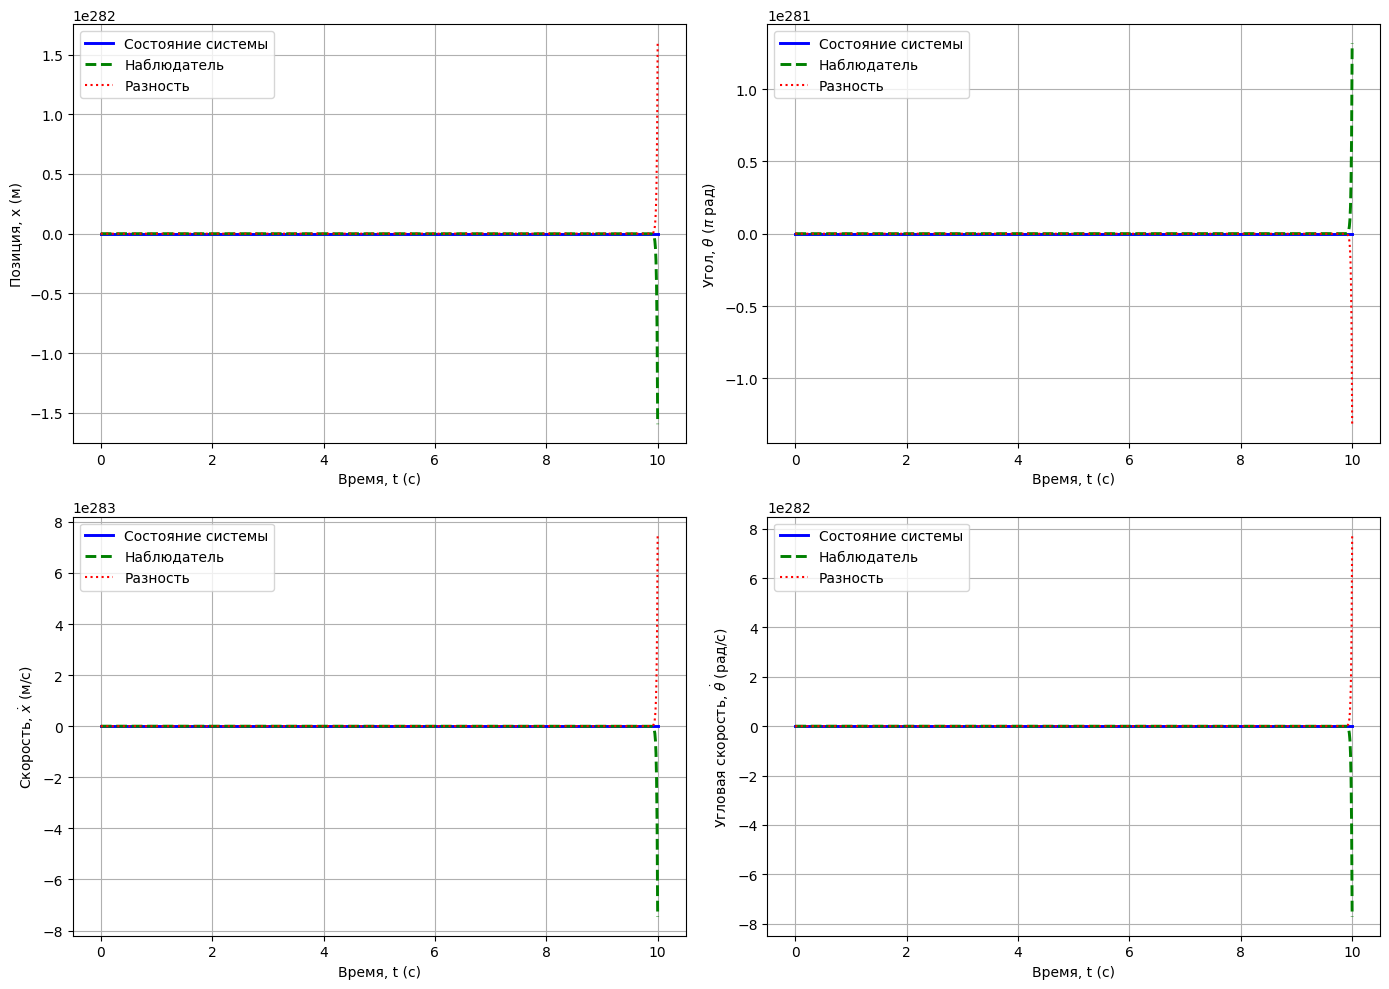

In [43]:
sol = solve_ivp(rhs_nonlinear_controlled, T_SPAN, INIT_POINT, t_eval=T_EVAL, method='RK45')

# Построение графиков
plt.figure(figsize=(14, 10))

# График x1 (позиция)
plt.subplot(2, 2, 1)
plt.plot(sol.t, sol.y[0], 'b-', label='Состояние системы', linewidth=2.1)
plt.plot(sol.t, sol.y[4], 'g--', label='Наблюдатель', linewidth=2.1)
plt.plot(sol.t, sol.y[0] - sol.y[4], 'r:', label='Разность', linewidth=1.5)
plt.xlabel('Время, t (с)')
plt.ylabel('Позиция, x (м)')
plt.grid(True)
plt.legend()

# График x2 (угол)
plt.subplot(2, 2, 2)
plt.plot(sol.t, sol.y[1]/np.pi, 'b-', label='Состояние системы', linewidth=2.1)
plt.plot(sol.t, sol.y[5]/np.pi, 'g--', label='Наблюдатель', linewidth=2.1)
plt.plot(sol.t, (sol.y[1] - sol.y[5])/np.pi, 'r:', label='Разность', linewidth=1.5)
plt.xlabel('Время, t (с)')
plt.ylabel(r'Угол, $\theta$ ($\pi$ рад)')
plt.grid(True)
plt.legend()

# График x3 (скорость позиции)
plt.subplot(2, 2, 3)
plt.plot(sol.t, sol.y[2], 'b-', label='Состояние системы', linewidth=2.1)
plt.plot(sol.t, sol.y[6], 'g--', label='Наблюдатель', linewidth=2.1)
plt.plot(sol.t, sol.y[2] - sol.y[6], 'r:', label='Разность', linewidth=1.5)
plt.xlabel('Время, t (с)')
plt.ylabel(r'Скорость, $\dot{x}$ (м/с)')
plt.grid(True)
plt.legend()

# График x4 (угловая скорость)
plt.subplot(2, 2, 4)
plt.plot(sol.t, sol.y[3], 'b-', label='Состояние системы', linewidth=2.1)
plt.plot(sol.t, sol.y[7], 'g--', label='Наблюдатель', linewidth=2.1)
plt.plot(sol.t, sol.y[3] - sol.y[7], 'r:', label='Разность', linewidth=1.5)
plt.xlabel('Время, t (с)')
plt.ylabel(r'Угловая скорость, $\dot{\theta}$ (рад/с)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# def plot_time(function):
#     def plot_time_sub(_fig = None, _axs = None, _fig_ctrl = None, _axs_ctrl = None, pnt = [0, 0, 0, 0], diff_scale = [1, 1, 1, 1], tlim = MAX_TIME_PLOT, clr1 = 'b-', clr2 = 'g:', clr3 = 'r-', is_controlled = False):
#         solution = solve_ivp(function, [0.0, tlim], pnt, method='RK45', rtol=RTOL_MAX)

#         data = {}
#         if _fig == None and _axs == None:
#             data["fig"], data["axs"] = plt.subplots((5) if (is_controlled) else (4), 1, figsize=(10, (25) if (is_controlled) else (20)))
#         else:
#             data["fig"], data["axs"] = _fig, _axs
        
#         data["axs"][0].set_xlabel("Время (t)")
#         data["axs"][0].set_ylabel('x')
#         data["axs"][0].plot(solution.t, solution.y[0], clr1)
#         data["axs"][0].plot(solution.t, solution.y[4], clr2)
#         data["axs"][0].plot(solution.t, abs(solution.y[4] - solution.y[0]) * diff_scale[0], clr3)
#         data["axs"][0].legend(["Состояние системы", "Состояние наблюдателя", "Разность"])
        
#         data["axs"][1].set_xlabel("Время (t)")
#         data["axs"][1].set_ylabel(r'$\theta$')
#         data["axs"][1].plot(solution.t, solution.y[2], clr1)
#         data["axs"][1].plot(solution.t, solution.y[6], clr2)
#         data["axs"][1].plot(solution.t, abs(solution.y[6] - solution.y[2]) * diff_scale[1], clr3)
#         data["axs"][1].legend(["Состояние системы", "Состояние наблюдателя", "Разность"])
        
#         data["axs"][2].set_xlabel("Время (t)")
#         data["axs"][2].set_ylabel(r'$\dot{x}$')
#         data["axs"][2].plot(solution.t, solution.y[1], clr1)
#         data["axs"][2].plot(solution.t, solution.y[5], clr2)
#         data["axs"][2].plot(solution.t, abs(solution.y[5] - solution.y[1]) * diff_scale[2], clr3)
#         data["axs"][2].legend(["Состояние системы", "Состояние наблюдателя", "Разность"])
        
#         data["axs"][3].set_xlabel("Время (t)")
#         data["axs"][3].set_ylabel(r'$\dot{\theta}$')
#         data["axs"][3].plot(solution.t, solution.y[3], clr1)
#         data["axs"][3].plot(solution.t, solution.y[7], clr2)
#         data["axs"][3].plot(solution.t, abs(solution.y[7] - solution.y[3]) * diff_scale[3], clr3)
#         data["axs"][3].legend(["Состояние системы", "Состояние наблюдателя", "Разность"])

#         if (is_controlled):
#             data["axs"][4].set_xlabel("Время (t)")
#             data["axs"][4].set_ylabel("Управление (U)")
#             control = [(CONTROL_COEFFICIENTS[0] * solution.y[4][i] +
#                        CONTROL_COEFFICIENTS[1] * solution.y[5][i] +
#                        CONTROL_COEFFICIENTS[2] * solution.y[6][i] +
#                        CONTROL_COEFFICIENTS[3] * solution.y[7][i]) for i in range(len(solution.t))]
#             data["axs"][4].plot(solution.t, control, clr1)

#         return data
#     return plot_time_sub

In [27]:
def plot_time(function):
    def plot_time_sub(_fig=None, _axs=None, _fig_ctrl=None, _axs_ctrl=None, 
                    pnt=INIT_POINT, diff_scale=[1, 1, 1, 1], tlim=MAX_TIME_PLOT, 
                    clr1='b-', clr2='g:', clr3='r-', is_controlled=False):
        
        solution = solve_ivp(function, [0.0, tlim], pnt, method='RK45', rtol=RTOL_MAX)

        data = {}
        if _fig is None and _axs is None:
            fig, axs = plt.subplots(5 if is_controlled else 4, 1, 
                                  figsize=(10, 25 if is_controlled else 20))
            data["fig"], data["axs"] = fig, axs
        else:
            data["fig"], data["axs"] = _fig, _axs
        
        # График положения x (x1)
        ax = data["axs"][0]
        ax.set_xlabel("Время (t)")
        ax.set_ylabel('x')
        ax.plot(solution.t, solution.y[0], clr1, label="Состояние системы")
        ax.plot(solution.t, solution.y[4], clr2, label="Состояние наблюдателя")
        ax.plot(solution.t, abs(solution.y[4] - solution.y[0]) * diff_scale[0], 
              clr3, label="Разность")
        ax.legend()
        ax.grid(True)

        # График скорости dx/dt (x3)
        ax = data["axs"][1]
        ax.set_xlabel("Время (t)")
        ax.set_ylabel(r'$\dot{x}$')
        ax.plot(solution.t, solution.y[2], clr1)
        ax.plot(solution.t, solution.y[6], clr2)
        ax.plot(solution.t, abs(solution.y[6] - solution.y[2]) * diff_scale[1], clr3)
        ax.legend(["Состояние системы", "Состояние наблюдателя", "Разность"])
        ax.grid(True)

        # График угла θ (x2)
        ax = data["axs"][2]
        ax.set_xlabel("Время (t)")
        ax.set_ylabel(r'$\theta$')
        ax.plot(solution.t, solution.y[1], clr1)
        ax.plot(solution.t, solution.y[5], clr2)
        ax.plot(solution.t, abs(solution.y[5] - solution.y[1]) * diff_scale[2], clr3)
        ax.legend(["Состояние системы", "Состояние наблюдателя", "Разность"])
        ax.grid(True)

        # График скорости dθ/dt (x4)
        ax = data["axs"][3]
        ax.set_xlabel("Время (t)")
        ax.set_ylabel(r'$\dot{\theta}$')
        ax.plot(solution.t, solution.y[3], clr1)
        ax.plot(solution.t, solution.y[7], clr2)
        ax.plot(solution.t, abs(solution.y[7] - solution.y[3]) * diff_scale[3], clr3)
        ax.legend(["Состояние системы", "Состояние наблюдателя", "Разность"])
        ax.grid(True)

        if is_controlled:
            # График управления
            ax = data["axs"][4]
            ax.set_xlabel("Время (t)")
            ax.set_ylabel("Управление (U)")
            control = [CONTROL_COEFFICIENTS[0] * solution.y[4][i] +
                      CONTROL_COEFFICIENTS[1] * solution.y[5][i] +
                      CONTROL_COEFFICIENTS[2] * solution.y[6][i] +
                      CONTROL_COEFFICIENTS[3] * solution.y[7][i] for i in range(len(solution.t))]
            ax.plot(solution.t, control, clr1)
            ax.grid(True)

        plt.tight_layout()
        return data
    return plot_time_sub

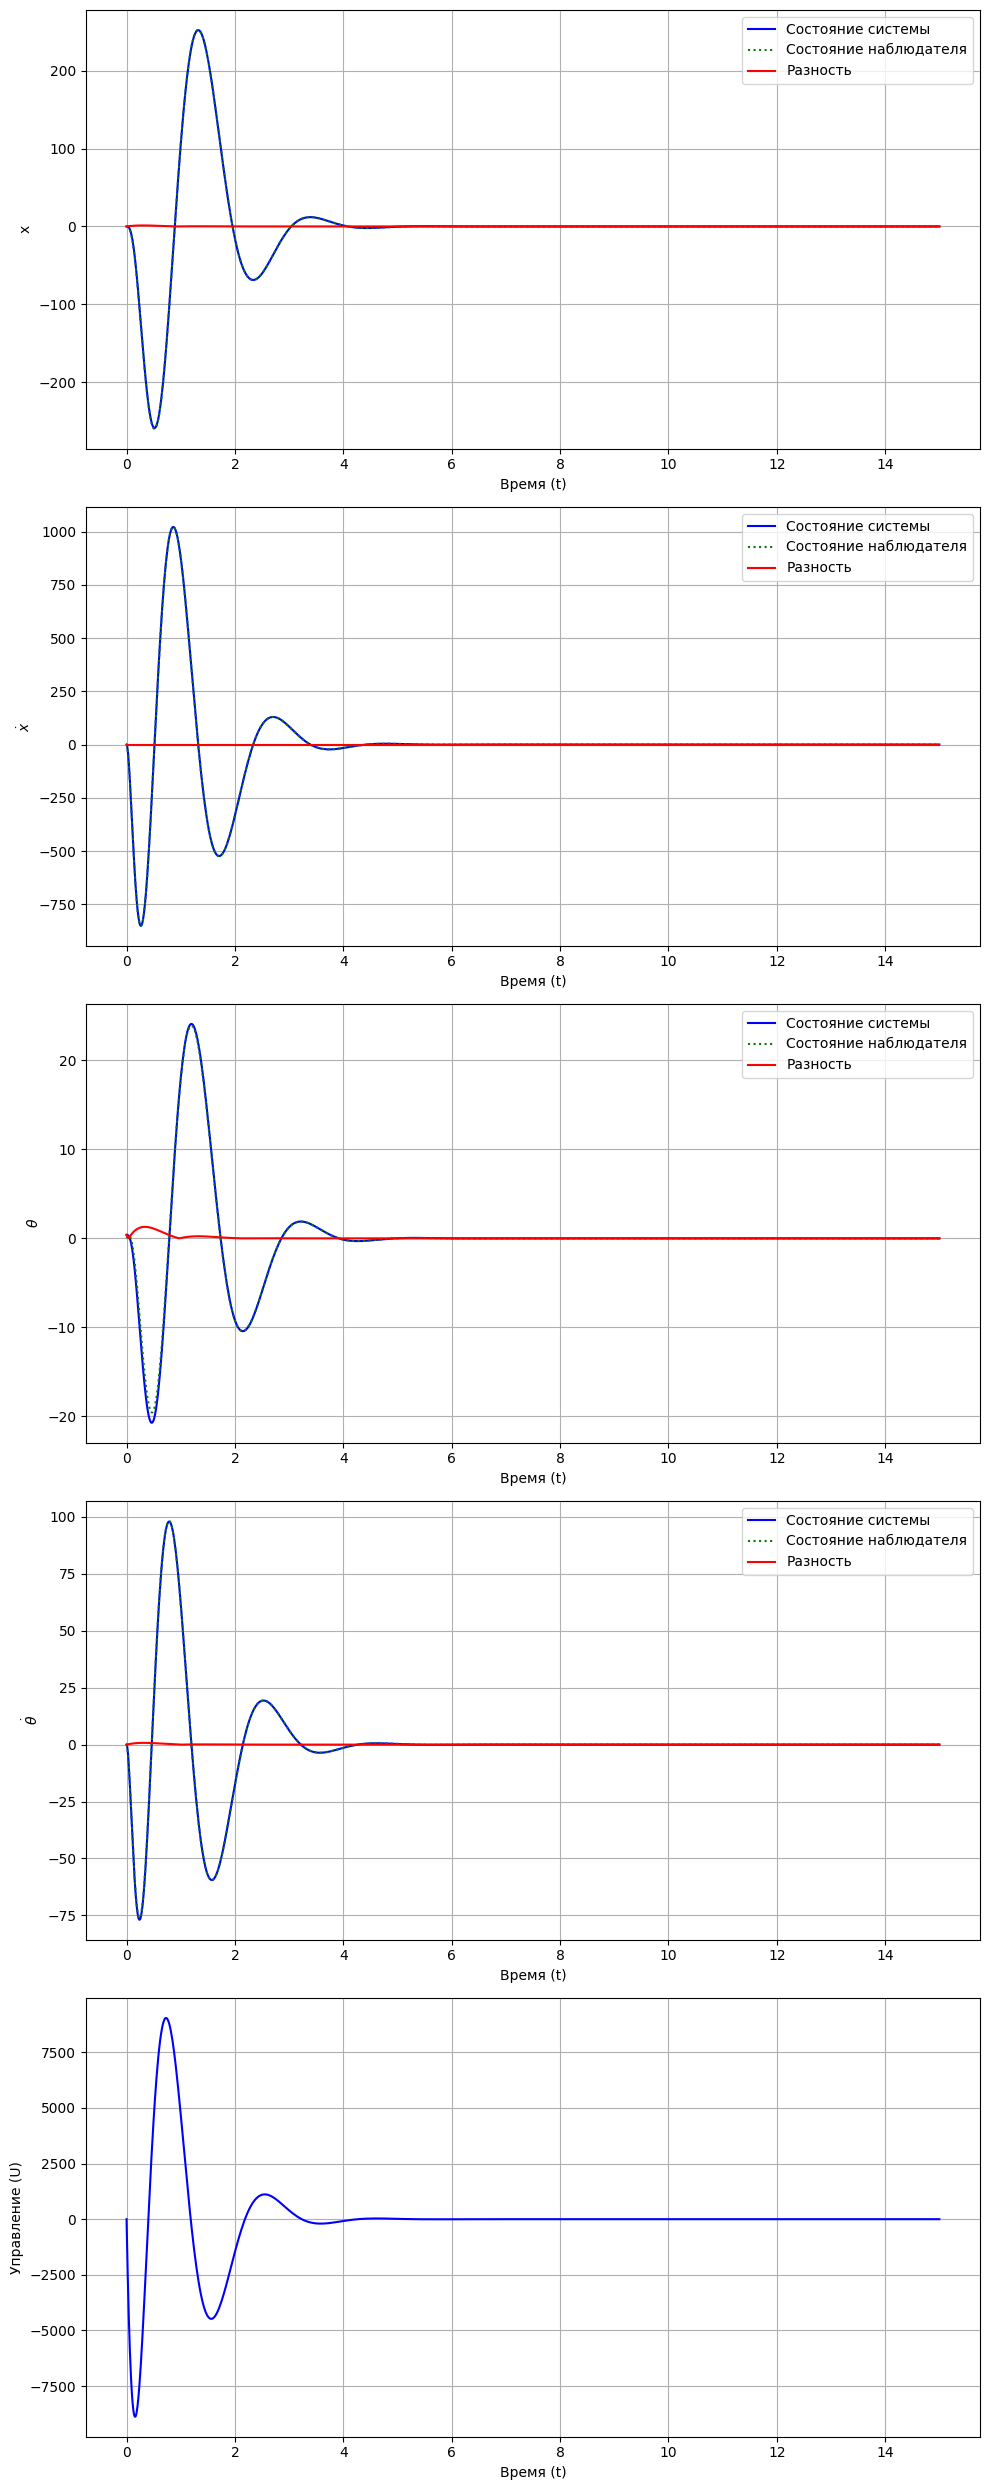

In [28]:
# Линейная система с управлением
# data = plot_time(rhs_linear_controlled)(pnt = INIT_POINT, is_controlled = True)
# fig, axs = data["fig"], data["axs"]

# plt.show()

plot_time_func = plot_time(rhs_linear_controlled)
data = plot_time_func(pnt=INIT_POINT, is_controlled=True)
plt.show()

In [39]:
# Нелинейная система с управлением
plot_time_func = plot_time(rhs_nonlinear_controlled)
data = plot_time_func(pnt=INIT_POINT, is_controlled=True)
plt.show()

KeyboardInterrupt: 

## 8

[[ -352.41154975 12782.89741533  -704.17548471  6308.84796545]]


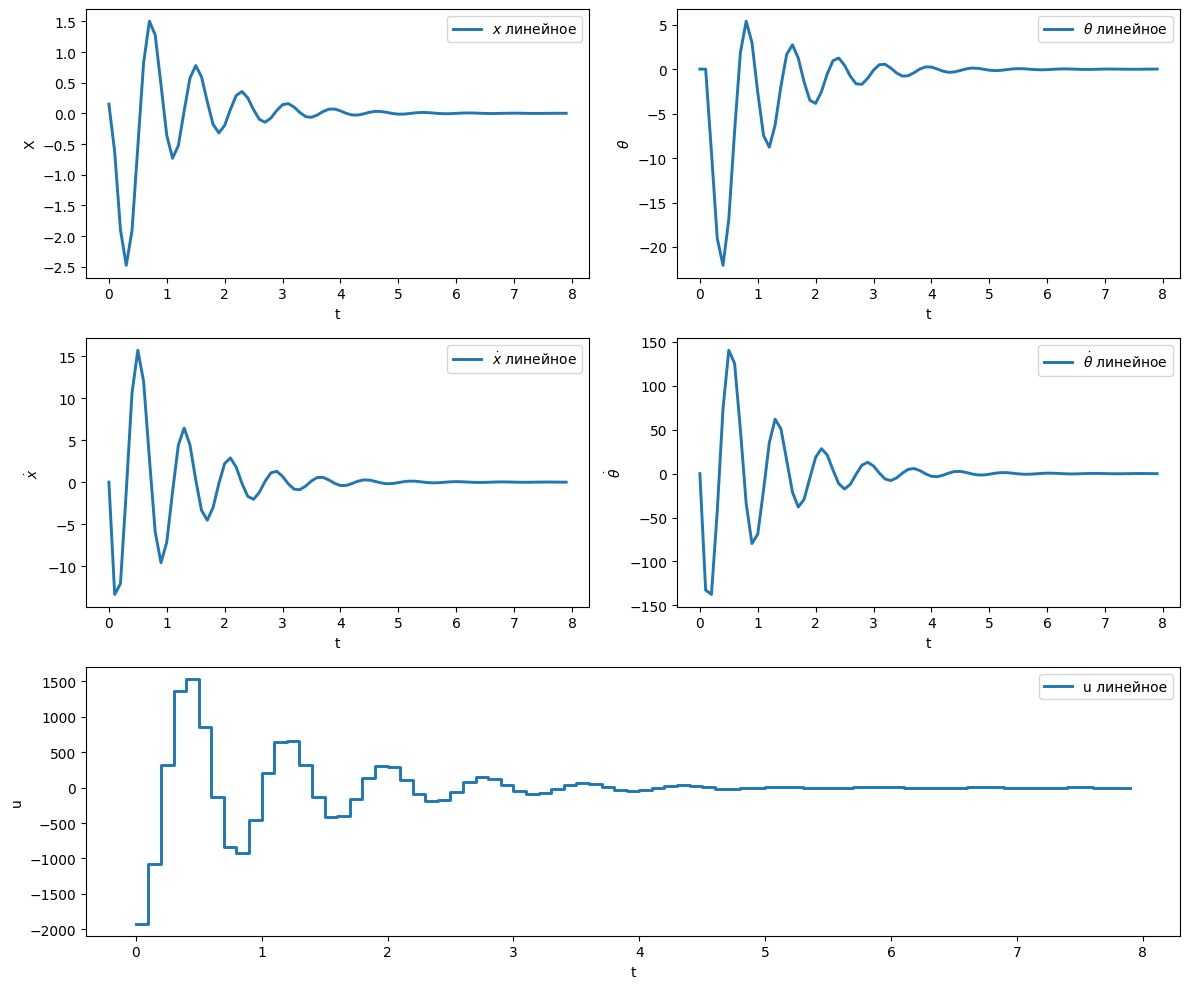

In [3]:
import numpy as np
from scipy.linalg import expm
from scipy.signal import place_poles

# Параметры системы
A = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [0, 0.060985, -7.4894, -0.0875],
    [0, 1.08167, -0.82153, -1.55195]
], dtype=np.float64)

B = np.array([[0], [0], [0.98343], [0.10787]], dtype=np.float64)

dt = 0.1  # Шаг дискретизации
T = 8.0    # Общее время моделирования
steps = int(T/dt)

# Дискретизация
A_d = expm(A * dt)
M = np.zeros((4,5))
M[:,:4] = A * dt
M[:,4:] = B * dt
B_d = np.linalg.pinv(A) @ (A_d - np.eye(4)) @ B

# Модальное управление
#desired_eigs = [0.4493, 0.4065, 0.902, 0.687]
#desired_eigs = [0.9048, 0.8187, 0.902, 0.687]
desired_eigs = [np.exp(-0.1+0.8j), np.exp(-0.1-0.8j), 0.902, 0.687]
#desired_eigs = [np.exp(-0.1+0.1j), np.exp(-0.1-0.1j), 0.902, 0.687]
place_result = place_poles(A_d, B_d, desired_eigs)
K = place_result.gain_matrix

print(K)
# Начальные условия
xi = np.array([0.0, 0.15, 0, 0])  # Начальное отклонение по θ

# Подготовка данных для сохранения
time = np.arange(0, T, dt)
states = np.zeros((4, len(time)))
controls = np.zeros(len(time))

# Генерация ступенчатого управления ("лесенка")
def step_signal(t):
    if t < 1.0: return 0.0
    elif t < 2.0: return 0.5
    elif t < 3.0: return 1.0
    elif t < 4.0: return 0.3
    else: return 0.7

# Интегрирование системы
for i, t in enumerate(time):
    # Ступенчатое управление + обратная связь
    u_ref = step_signal(t)
    u = u_ref - K @ xi.reshape(-1,1)  # xi должен быть вектором-столбцом для умножения
    
    # Сохранение состояния и управления
    states[:,i] = xi  # xi имеет форму (4,), states[:,i] тоже (4,)
    controls[i] = u.item()  # Извлекаем скалярное значение
    
    # Переход к следующему состоянию
    xi = (A_d @ xi.reshape(-1,1) + B_d * u).flatten()  # Результат приводим к форме (4,)

plt.figure(figsize=(12, 10))  # Увеличиваем высоту фигуры

# График x (позиция)
plt.subplot(3, 2, 1)
plt.plot(time, states[1,:], label='$x$ линейное', linewidth = 2.1)
plt.xlabel('t')
plt.ylabel('X')
plt.grid(False)
plt.legend()

# График θ (угол)
plt.subplot(3, 2, 2)
plt.plot(time, states[0,:], label=r'$\theta$ линейное', linewidth = 2.1)
plt.xlabel('t')
plt.ylabel(r'$\theta$')
plt.grid(False)
plt.legend()

# График dx/dt (скорость позиции)
plt.subplot(3, 2, 3)
plt.plot(time, states[3,:], label=r'$\dot{x}$ линейное', linewidth = 2.1)
plt.xlabel('t')
plt.ylabel(r'$\dot{x}$')
plt.grid(False)
plt.legend()

# График dθ/dt (угловая скорость)
plt.subplot(3, 2, 4)
plt.plot(time, states[2,:], label=r'$\dot{\theta}$ линейное', linewidth = 2.1)
plt.xlabel('t')
plt.ylabel(r'$\dot{\theta}$')
plt.grid(False)
plt.legend()

# График управления (занимает две колонки)
plt.subplot(3, 1, 3)
plt.step(time, controls, where='post', label='u линейное', linewidth = 2.1)
plt.xlabel('t')
plt.ylabel('u')
plt.grid(False)
plt.legend()

plt.tight_layout()
plt.show()

## 9

[[ 0.36679149  0.62895403]
 [-0.65417723  0.42588042]
 [ 0.03318829  0.01458084]
 [-0.31322451  0.30416578]]


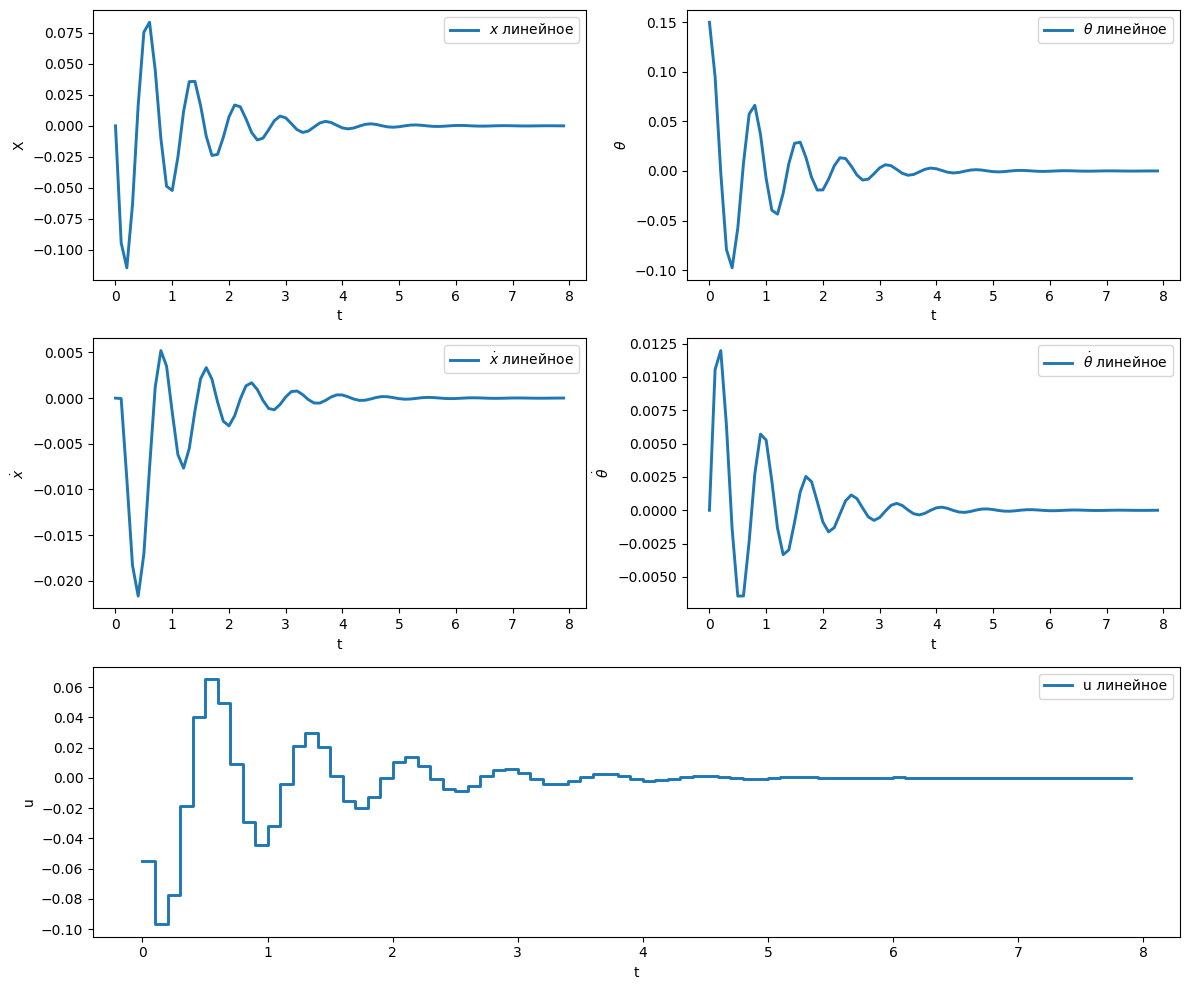

In [10]:
import numpy as np
from scipy.linalg import expm
from scipy.signal import place_poles
import matplotlib.pyplot as plt

# Параметры системы
A = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [0, 0.060985, -7.4894, -0.0875],
    [0, 1.08167, -0.82153, -1.55195]
], dtype=np.float64)

B = np.array([[0], [0], [0.98343], [0.10787]], dtype=np.float64)
C = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])  # Измеряем только x и θ

dt = 0.1  # Шаг дискретизации
T = 8.0    # Время моделирования

# Дискретизация системы
A_d = expm(A * dt)
B_d = np.linalg.pinv(A) @ (A_d - np.eye(4)) @ B

# Полюса наблюдателя (должны быть быстрее полюсов системы)
#observer_poles = [0.4493, 0.81387757, 0.47222821, 0.4065]  # Более быстрые полюса для лучшей сходимости
observer_poles = [np.exp(-0.1+0.8j), 0.81387757, 0.47222821, np.exp(-0.1-0.8j)]  # Более быстрые полюса для лучшей сходимости
# Расчет матрицы усиления наблюдателя
L = place_poles(A_d.T, C.T, observer_poles).gain_matrix.T

eigenvalues, eigenvectors = np.linalg.eig(A_d.T)

# Инициализация наблюдателя
xi = np.array([0.15, 0.0, 0.0, 0.0])  # Начальная оценка

# Подготовка данных для сохранения
time = np.arange(0, T, dt)
states = np.zeros((4, len(time)))
controls = np.zeros(len(time))

# Генерация ступенчатого управления ("лесенка")
def step_signal(t):
    if t < 1.0: return 0.0
    elif t < 2.0: return 0.5
    elif t < 3.0: return 1.0
    elif t < 4.0: return 0.3
    else: return 0.7
print(L)
# Моделирование работы наблюдателя
for i, t in enumerate(time):
    
    states[:, i] = xi

    u_ref = step_signal(t)
    u = -L.T @ xi.reshape(-1,1) 

    #xi = (A_d.T @ xi.reshape(-1,1) + C.T @ (-L.T @ xi.reshape(-1,1))).flatten()
    xi = (A_d.T @ xi.reshape(-1,1) + C.T @ u).flatten()
    
    controls[i] = u[0, 0]  # Извлекаем скалярное значение

# Визуализация результатов работы наблюдателя
plt.figure(figsize=(12, 10))

# График x (позиция)
plt.subplot(3, 2, 1)
plt.plot(time, states[1,:], label='$x$ линейное', linewidth = 2.1)
plt.xlabel('t')
plt.ylabel('X')
plt.grid(False)
plt.legend()

# График θ (угол)
plt.subplot(3, 2, 2)
plt.plot(time, states[0,:], label=r'$\theta$ линейное', linewidth = 2.1)
plt.xlabel('t')
plt.ylabel(r'$\theta$')
plt.grid(False)
plt.legend()

# График dx/dt (скорость позиции)
plt.subplot(3, 2, 3)
plt.plot(time, states[3,:], label=r'$\dot{x}$ линейное', linewidth = 2.1)
plt.xlabel('t')
plt.ylabel(r'$\dot{x}$')
plt.grid(False)
plt.legend()

# График dθ/dt (угловая скорость)
plt.subplot(3, 2, 4)
plt.plot(time, states[2,:], label=r'$\dot{\theta}$ линейное', linewidth = 2.1)
plt.xlabel('t')
plt.ylabel(r'$\dot{\theta}$')
plt.grid(False)
plt.legend()

# График управления (занимает две колонки)
plt.subplot(3, 1, 3)
plt.step(time, controls, where='post', label='u линейное', linewidth = 2.1)
plt.xlabel('t')
plt.ylabel('u')
plt.grid(False)
plt.legend()

plt.tight_layout()
plt.show()

## 10

L:
 [[ 0.39199893  0.08864287]
 [-0.12672621  0.47260471]
 [ 0.02573485  0.03002912]
 [-0.03088925  0.26529174]]


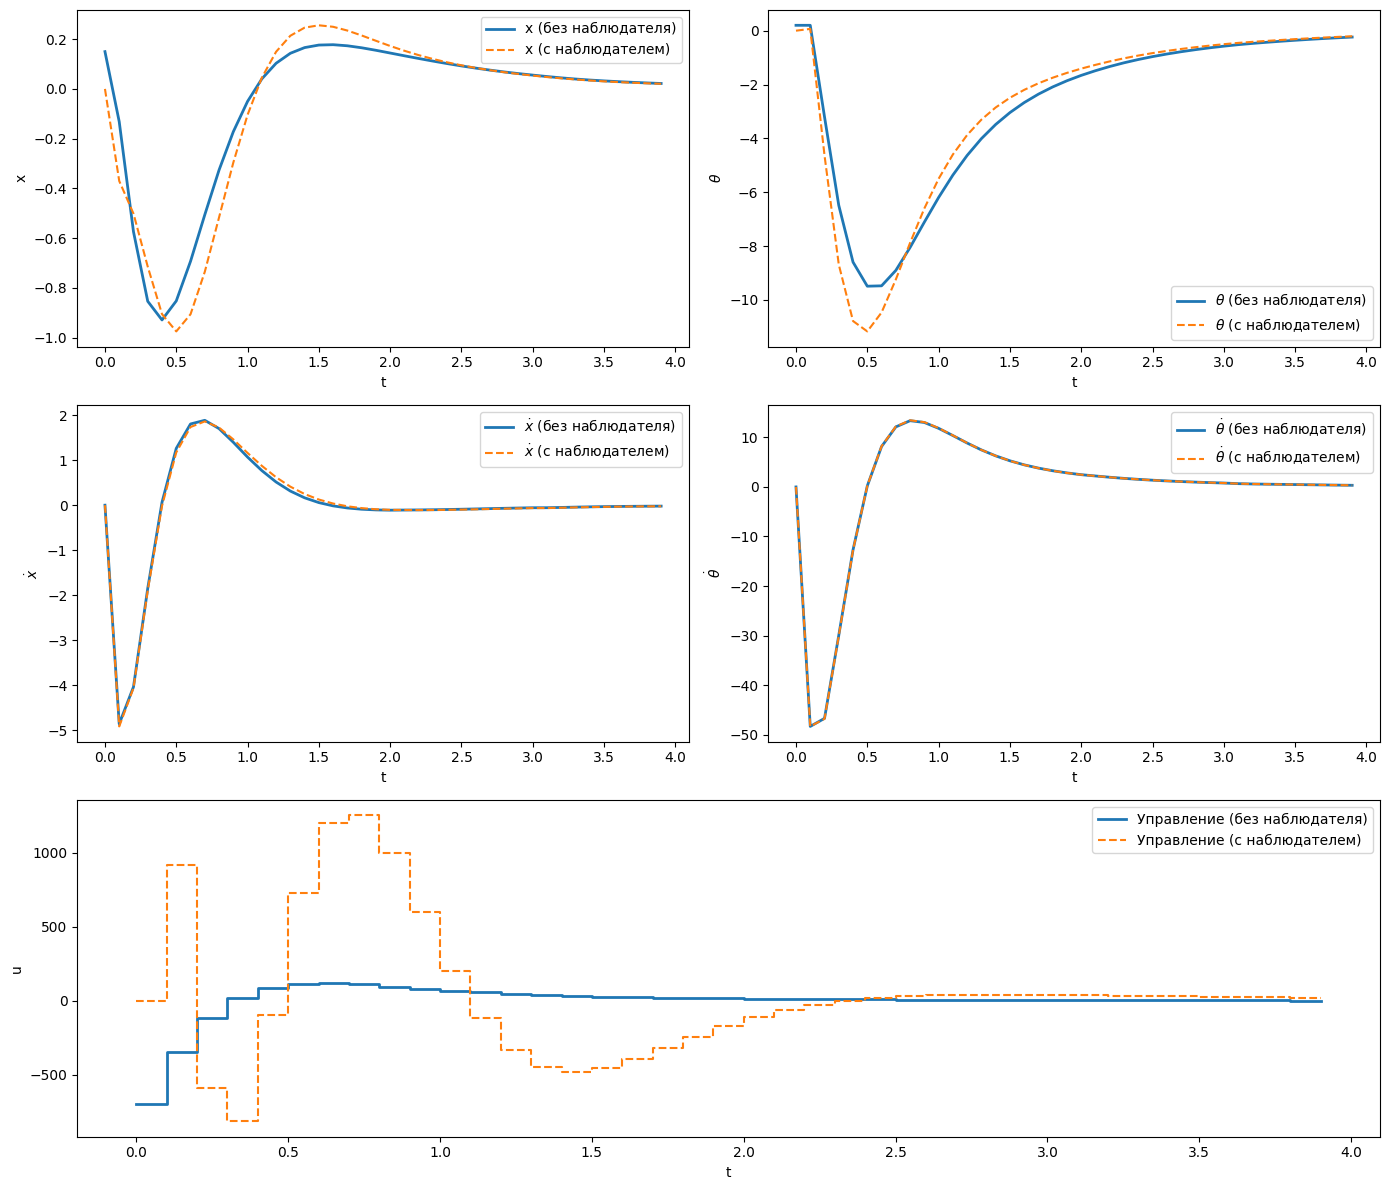

In [ ]:
import numpy as np
from scipy.linalg import expm
from scipy.signal import place_poles
import matplotlib.pyplot as plt

# Параметры системы
A = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [0, 0.060985, -7.4894, -0.0875],
    [0, 1.08167, -0.82153, -1.55195]
], dtype=np.float64)

B = np.array([[0], [0], [0.98343], [0.10787]], dtype=np.float64)
C = np.array([[1, 0, 0, 0], [0, 1, 0, 0]]) 

dt = 0.1  # Шаг дискретизации
T = 4.0    # Общее время моделирования

# Дискретизация системы
A_d = expm(A * dt)
B_d = np.linalg.pinv(A) @ (A_d - np.eye(4)) @ B

# Полюса регулятора (комплексно-сопряженные для плавности)
regulator_poles = [np.exp(-0.5+0.2j), np.exp(-0.5-0.2j), 0.902, 0.687]
#regulator_poles = [0.4493, 0.4065, 0.902, 0.687]
#regulator_poles = [0.9048, 0.8187, 0.902, 0.687]
K = place_poles(A_d, B_d, regulator_poles).gain_matrix

#print("Theta: ", K)

# Полюса наблюдателя (быстрее регулятора)
#observer_poles = [0.4493, 0.81387757, 0.47222821, 0.4065]
#observer_poles = [0.9048, 0.81387757, 0.47222821, 0.8187]
observer_poles = [np.exp(-0.5+0.2j), 0.81387757, 0.47222821, np.exp(-0.5-0.2j)]
L = place_poles(A_d.T, C.T, observer_poles).gain_matrix.T

print("L:\n", L)


real_state = np.array([0.2, 0.15, 0.0, 0.0]) 
estimated_state = np.array([0.0, 0.0, 0.0, 0.0])  

time = np.arange(0, T, dt)
states_real = np.zeros((4, len(time))) 
states_est = np.zeros((4, len(time)))  
controls_real = np.zeros(len(time))   
controls_est = np.zeros(len(time))    

def step_signal(t):
    if t < 1.0: return 0.0
    elif t < 2.0: return 0.5
    elif t < 3.0: return 1.0
    elif t < 4.0: return 0.3
    else: return 0.7

for i, t in enumerate(time):
    u_ref = step_signal(t)
    
    u_real = u_ref-K @ real_state.reshape(-1,1)
    states_real[:,i] = real_state
    real_state = (A_d @ real_state.reshape(-1,1) + B_d * u_real).flatten()
    controls_real[i] = u_real.item()
    
    u_est = u_ref-K @ estimated_state.reshape(-1,1)

    y = C @ real_state.reshape(-1,1) 
    states_est[:,i] = estimated_state
    estimated_state = ((A_d @ estimated_state.reshape(-1,1) + 
                      B_d * u_real) + 
                      L @ (y - C @ estimated_state.reshape(-1,1))).flatten() 
    
    controls_est[i] = u_est[0, 0]


plt.figure(figsize=(14, 12))

plt.subplot(3, 2, 1)  
plt.plot(time, states_real[1,:], label='x (без наблюдателя)', linewidth=2)
plt.plot(time, states_est[1,:], label='x (с наблюдателем)', linestyle = '--')
plt.xlabel('t')
plt.ylabel('x')
plt.grid(False)
plt.legend()

plt.subplot(3, 2, 2)  
plt.plot(time, states_real[0,:], label=r'$\theta$ (без наблюдателя)', linewidth=2)
plt.plot(time, states_est[0,:], label=r'$\theta$ (с наблюдателем)', linestyle = '--')
plt.xlabel('t')
plt.ylabel(r'$\theta$')
plt.grid(False)
plt.legend()

plt.subplot(3, 2, 3)  
plt.plot(time, states_real[3,:], label=r'$\dot{x}$ (без наблюдателя)', linewidth=2)
plt.plot(time, states_est[3,:], label=r'$\dot{x}$ (с наблюдателем)', linestyle = '--')
plt.xlabel('t')
plt.ylabel(r'$\dot{x}$')
plt.grid(False)
plt.legend()

plt.subplot(3, 2, 4)  
plt.plot(time, states_real[2,:], label=r'$\dot{\theta}$ (без наблюдателя)', linewidth=2)
plt.plot(time, states_est[2,:], label=r'$\dot{\theta}$ (с наблюдателем)', linestyle = '--')
plt.xlabel('t')
plt.ylabel(r'$\dot{\theta}$')
plt.grid(False)
plt.legend()

plt.subplot(3, 1, 3)  
plt.step(time, controls_real, where='post', label='Управление (без наблюдателя)', linewidth=2)
plt.step(time, controls_est, where='post', label='Управление (с наблюдателем)', linestyle = '--')
plt.xlabel('t')
plt.ylabel('u')
plt.grid(False)
plt.legend()

plt.tight_layout()
plt.show()